In [1]:
from Initialization import *

c:\libs\pycqed_py3\data
Data directory set to: c:\libs\pycqed_py3\data
c:\libs\pycqed_py3\data
Connected to: Agilent Technologies N5183B (serial:MY53271678, firmware:B.01.60) in 0.10s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/101645, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: SONY/TEK AWG520 (serial:0, firmware:SCPI:95.0 OS:1.0 USR:1.3a) in 0.12s


C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning:

ask is deprecated and will be removed in 1.10, use query instead.

c:\libs\qcodes\qcodes\instrument\parameter.py:247: UserWarning:

Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.

Snapshot: Could not update parameter: clock_source on ATS
Snapshot: Could not update parameter: sample_rate on ATS
Snapshot: Could not update parameter: clock_edge on ATS
Snapshot: Could not update parameter: decimation on ATS
Snapshot: Could not update parameter: coupling1 on ATS
Snapshot: Could not update parameter: channel_range1 on ATS
Snapshot: Could not update parameter: impedance1 on ATS
Snapshot: Could not update parameter: bwlimit1 on ATS
Snapshot: Could not update parameter: coupling2 on ATS
Snapshot: Could not update parameter: channel_range2 on ATS
Snapshot: Could not update parameter: impedance2 on ATS
Snapshot: C

controller initialized


In [3]:
station.components

NameError: name 'station' is not defined

In [3]:
station.AWG

<Tektronix_AWG520: AWG>

In [4]:
SPEC.power()

19.0

In [5]:
RFLO.power(16)
RFLO.on()

In [6]:
SPEC.power(-10)
SPEC.IQ_state('ON')  
SPEC.frequency(6.1565e9-0.05e9)
SPEC.off()

In [2]:
ATS.config(clock_source='EXTERNAL_CLOCK_10_MHz_REF',
                sample_rate='1GHz_REFERENCE_CLOCK',
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_NEGATIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='AC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0
)

NameError: name 'ATS' is not defined

In [3]:
ATS.config(clock_source='INTERNAL_CLOCK',
                sample_rate=1e9,
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],   
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='AC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0
)

In [41]:
# configure the ATS controller
ATS_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=4096*1,
                 records_per_buffer=4000,#70, segmments
                 buffers_per_acquisition=1,
                 channel_selection='AB',
                 transfer_offset=0,
                 external_startcapture='ENABLED',
                 enable_record_headers='DISABLED',
                 alloc_buffers='DISABLED',
                 fifo_only_streaming='DISABLED',
                 interleave_samples='DISABLED',
                 get_processed_data='DISABLED',
                 allocated_buffers=1,  
                 buffer_timeout=5000,
)


In [5]:
def ATS_homodyne_acquisition(integration_start, integration_time):
    
    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.allocated_buffers()

#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
    average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.
    
    offset_I = np.average(average_record_I[3000:4000])
    offset_Q = np.average(average_record_Q[3000:4000])
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
#     integrated_output_I = np.average(average_record_I[integration_start:integration_end])#/range_I
#     integrated_output_Q = np.average(average_record_Q[integration_start:integration_end])#/range_Q
    
    
    integrated_output_I = np.average(average_record_I[integration_start:integration_end]-offset_I)#/range_I
    integrated_output_Q = np.average(average_record_Q[integration_start:integration_end]-offset_Q)#/range_Q
    
    return [integrated_output_I, integrated_output_Q, offset_I, offset_Q]

In [ ]:
%matplotlib inline

In [6]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
# measurement_trigger_delay=500e-9   
# SSB_modulation_frequency=50e6
# measurement_pulse_length=1000e-9
# spec_pulse_length=20e-6
# spec_pulse_measurement_delay=30e-9
# buffer_pulse_length = 1.e-6
# readout_trigger_length = 500e-9  
# spec_pulse_amp=0.3

In [7]:
AWG.set_sequence('rabi_sequence_FILE.seq')

[12.142902999999999,
 -4.1043379999999932,
 -87.282415999999998,
 -51.568441000000007]

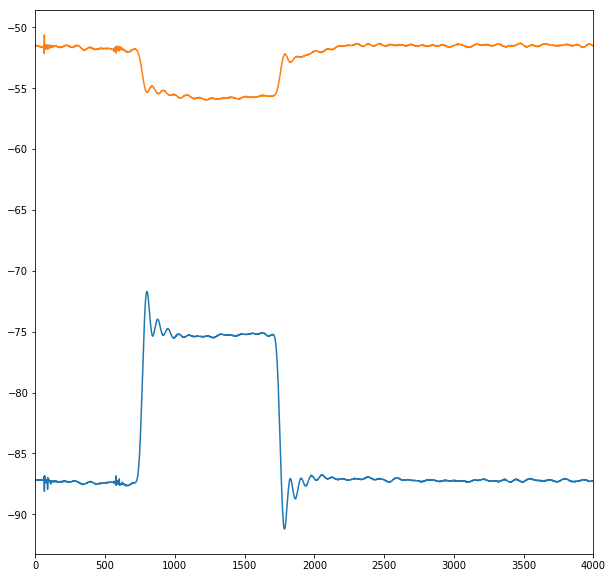

In [308]:
integration_start=800
integration_end=integration_start+500
AWG.set_sequence('rabi_sequence_FILE.seq')
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
RFLO.frequency(6.158e9)
SPEC.frequency(5.2737e9+0.05e9)  
SPEC.power(10)
RFLO.power(13)
RFLO.on()
SPEC.off()
SPEC.IQ_state.set('ON')
ATS.external_trigger_coupling._set_updated()
ATS.external_trigger_range._set_updated()

ATS_controller.pre_acquire()
blub = ATS_controller.do_acquisition()
ATS_controller.post_acquire()

buffer = ATS_controller.buffer
reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(),ATS.samples_per_record())/ATS.allocated_buffers()

# reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.allocated_buffers()-128.

# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_b uffer.flatten())[:50]])

average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.

# integrated_output_power = np.average((average_record_I[integration_start:integration_end]
#                                      +average_record_Q[integration_start:integration_end])**2)
# integrated_output_power = np.average(((average_record_I[integration_start:integration_end])**2
#                                      +(average_record_Q[integration_start:integration_end])**2))**0.5


plt.figure(figsize=(10,10))
plt.plot(average_record_I)
plt.plot(average_record_Q)
# plt.plot((average_record_Q**2+average_record_I**2)**0.5)
plt.xlim(0,4000)
ATS_homodyne_acquisition(800,500)
# plt.ylim(-5,-1)

# Homodyne voltage drift

In [252]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
Scans = np.linspace(0, 30000, 30001)
integrated_output = []
SPEC.power.set(-5)
SPEC.IQ_state.set('ON')
SPEC.off()     
RFLO.power(13.0)
RFLO.frequency.set(6.1585e9)   
for i, Scan in enumerate(Scans):
    SPEC.frequency.set(frequency+0.05e9)
    integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)
    
integrated_output = np.array(integrated_output)


Text(0,0.5,'Homodyne voltage (a.u.)')

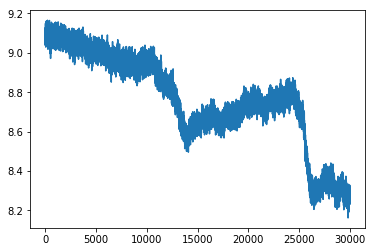

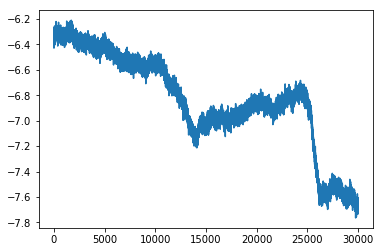

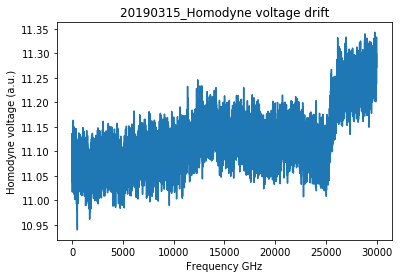

In [253]:
plt.figure()
plt.plot(Scans, integrated_output[:,0])
plt.figure()
plt.plot(Scans, integrated_output[:,1])   
  
plt.figure()
plt.plot(Scans, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
plt.title('20190315_Homodyne voltage drift')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
# plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# plt.savefig('foo.png', dpi=300, bbox_inches='tight')

In [254]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
Scans = np.linspace(0, 30000, 30001)
integrated_output = []
SPEC.power.set(-5)
SPEC.IQ_state.set('ON')
SPEC.off()     
RFLO.power(19.0)
RFLO.frequency.set(6.1585e9)   
for i, Scan in enumerate(Scans):
    SPEC.frequency.set(frequency+0.05e9)
    integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)
    
integrated_output = np.array(integrated_output)


Text(0,0.5,'Homodyne voltage (a.u.)')

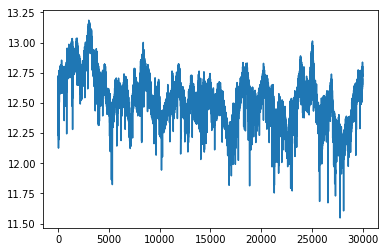

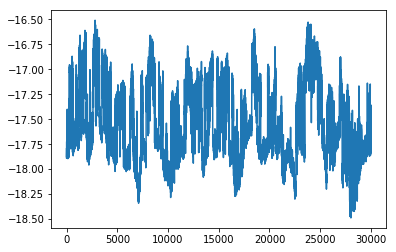

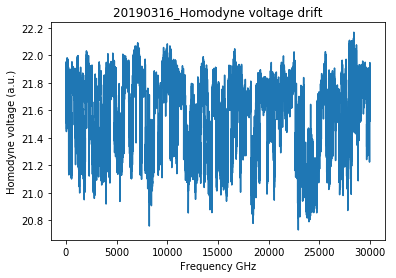

In [255]:
plt.figure()
plt.plot(Scans, integrated_output[:,0])
plt.figure()
plt.plot(Scans, integrated_output[:,1])   
  
plt.figure()
plt.plot(Scans, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
plt.title('20190316_Homodyne voltage drift')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
# plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# plt.savefig('foo.png', dpi=300, bbox_inches='tight')

In [256]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
Scans = np.linspace(0, 30000, 30001)
integrated_output = []
SPEC.power.set(-5)
SPEC.IQ_state.set('ON')
SPEC.off()     
RFLO.power(16.0)
RFLO.frequency.set(6.1585e9)   
for i, Scan in enumerate(Scans):
    SPEC.frequency.set(frequency+0.05e9)
    integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)
    
integrated_output = np.array(integrated_output)


Text(0,0.5,'Homodyne voltage (a.u.)')

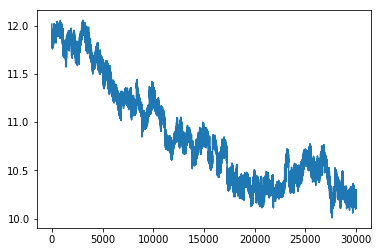

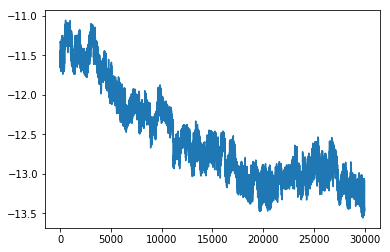

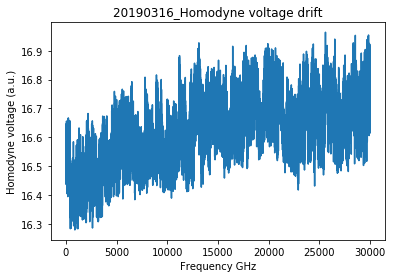

In [257]:
plt.figure()
plt.plot(Scans, integrated_output[:,0])
plt.figure()
plt.plot(Scans, integrated_output[:,1])   
  
plt.figure()
plt.plot(Scans, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
plt.title('20190316_Homodyne voltage drift')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
# plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# plt.savefig('foo.png', dpi=300, bbox_inches='tight')

# Pulse Spectroscopy-multi scan

0
1
2
3
4


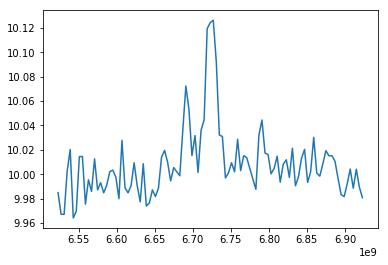

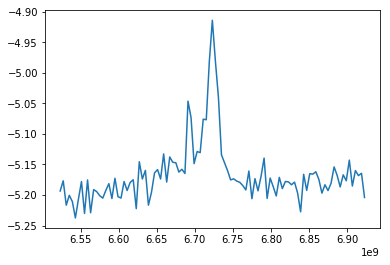

In [22]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(6.723e9-0.2e9, 6.723e9+0.2e9,101)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-10)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(6.158e9)  
length=5

for ii in range(0,length):
    print(ii)
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency.set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)

integrated_output = np.array(integrated_output)

data_I =np.mean(integrated_output[:,0].reshape(length,101),axis=0)
data_Q =np.mean(integrated_output[:,1].reshape(length,101),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I)
plt.figure()
plt.plot(spec_frequencies, data_Q)   
  
# plt.figure()
# plt.plot(spec_frequencies, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
# plt.title('Pulse spectroscopy')
# plt.xlabel('Frequency GHz')
# plt.ylabel('Homodyne voltage (a.u.)')  
# # plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# # plt.savefig('foo.png', dpi=300, bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9


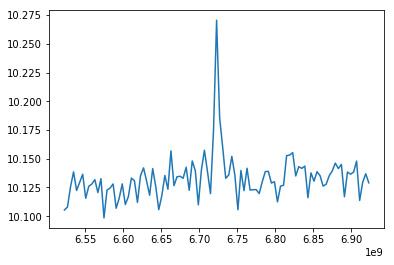

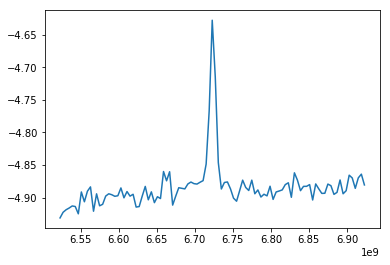

In [27]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(6.723e9-0.2e9, 6.723e9+0.2e9,101)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-15)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(6.158e9)  
length=10

for ii in range(0,length):
    print(ii)
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency  .set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)

integrated_output = np.array(integrated_output)

data_I =np.mean(integrated_output[:,0].reshape(length,101),axis=0)
data_Q =np.mean(integrated_output[:,1].reshape(length,101),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I)
plt.figure()
plt.plot(spec_frequencies, data_Q)   
  
# plt.figure()
# plt.plot(spec_frequencies, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
# plt.title('Pulse spectroscopy')
# plt.xlabel('Frequency GHz')
# plt.ylabel('Homodyne voltage (a.u.)')  
# # plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# # plt.savefig('foo.png', dpi=300, bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


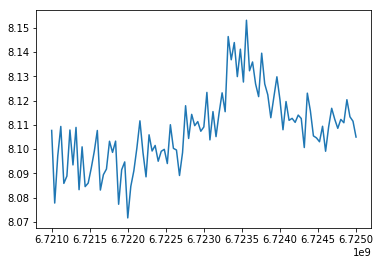

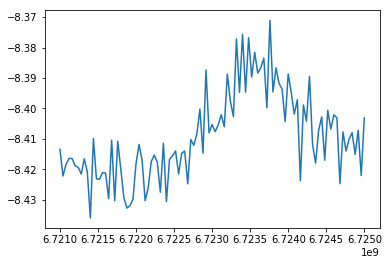

In [17]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(6.723e9-0.005e9, 6.723e9+0.005e9,101)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-30)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(6.158e9)  
length=20

for ii in range(0,length):
    print(ii)
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency.set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)

integrated_output = np.array(integrated_output)

data_I =np.mean(integrated_output[:,0].reshape(length,101),axis=0)
data_Q =np.mean(integrated_output[:,1].reshape(length,101),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I)
plt.figure()
plt.plot(spec_frequencies, data_Q)   
  
# plt.figure()
# plt.plot(spec_frequencies, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
# plt.title('Pulse spectroscopy')
# plt.xlabel('Frequency GHz')
# plt.ylabel('Homodyne voltage (a.u.)')  
# # plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# # plt.savefig('foo.png', dpi=300, bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


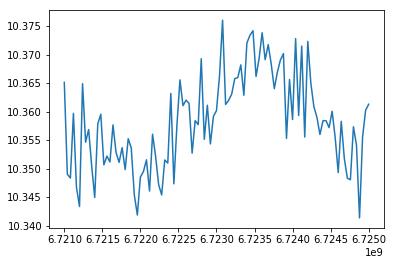

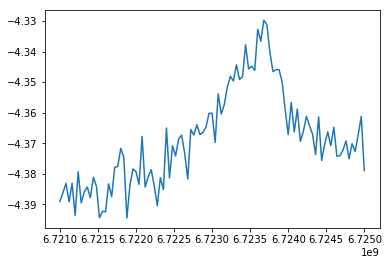

In [28]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9,101)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-40)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(6.158e9)  
length=50

for ii in range(0,length):
    print(ii)
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency.set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)

integrated_output = np.array(integrated_output)

data_I =np.mean(integrated_output[:,0].reshape(length,101),axis=0)
data_Q =np.mean(integrated_output[:,1].reshape(length,101),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I)
plt.figure()
plt.plot(spec_frequencies, data_Q)   
  
# plt.figure()
# plt.plot(spec_frequencies, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
# plt.title('Pulse spectroscopy')
# plt.xlabel('Frequency GHz')
# plt.ylabel('Homodyne voltage (a.u.)')  
# # plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# # plt.savefig('foo.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 101
    # variables        = 4
    chi-square         = 0.00302772
    reduced chi-square = 3.1214e-05
    Akaike info crit   = -1043.92157
    Bayesian info crit = -1033.46108
[[Variables]]
    x0:      6.7236e+09 +/- 51256.8444 (0.00%) (init = 6.723e+09)
    amp:     43248.6619 +/- 9378.53305 (21.69%) (init = 100000)
    gamma:   1349015.91 +/- 255821.547 (18.96%) (init = 500000)
    offset:  10.3499403 +/- 0.00155946 (0.02%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, offset)   = -0.928
    C(amp, gamma)    =  0.907
    C(gamma, offset) = -0.795



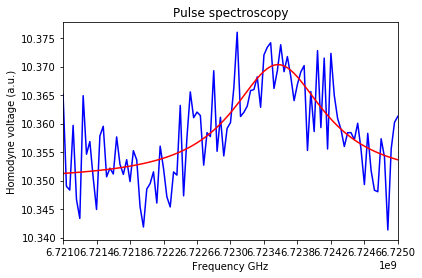

In [29]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
y=data_I

gmodel = Model(lorentzian)
result = gmodel.fit(y,x=f,amp=1e5,gamma=5e+5, x0=1*6.723e+9,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'b-')
# plt.plot(f, result.init_fit, 'k--') 
plt.plot(f, result.best_fit, 'r-')
plt.xlim(6.723e9-0.002e9, 6.723e9+0.002e9)
plt.title('Pulse spectroscopy')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9, 11))
plt.savefig('pulse_spec_W2-3D_HF_20190314_-40dBm_I.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 101
    # variables        = 4
    chi-square         = 0.00360834
    reduced chi-square = 3.7199e-05
    Akaike info crit   = -1026.20255
    Bayesian info crit = -1015.74207
[[Variables]]
    x0:      6.7236e+09 +/- 23425.3587 (0.00%) (init = 6.723e+09)
    amp:     97351.3971 +/- 9579.25274 (9.84%) (init = 100000)
    gamma:   1297155.76 +/- 113647.701 (8.76%) (init = 500000)
    offset: -4.38762880 +/- 0.00162494 (0.04%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, offset)   = -0.921
    C(amp, gamma)    =  0.902
    C(gamma, offset) = -0.784



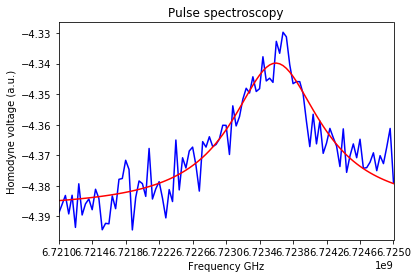

In [30]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
y=data_Q

gmodel = Model(lorentzian)
result = gmodel.fit(y,x=f,amp=1e5,gamma=5e+5, x0=1*6.723e+9,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'b-')
# plt.plot(f, result.init_fit, 'k--') 
plt.plot(f, result.best_fit, 'r-')
plt.xlim(6.723e9-0.002e9, 6.723e9+0.002e9)
plt.title('Pulse spectroscopy')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9, 11))
plt.savefig('pulse_spec_W2-3D_HF_20190314_-40dBm_Q.png', dpi=300, bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


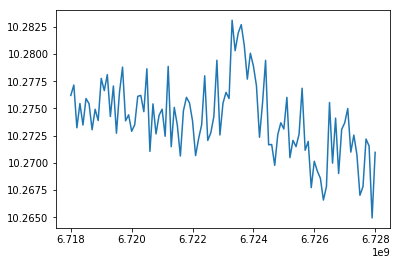

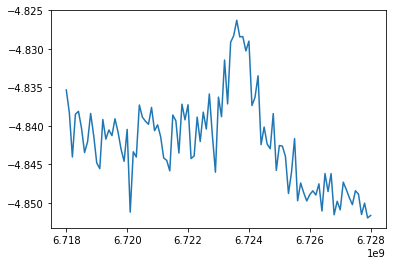

In [52]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(6.723e9-0.005e9, 6.723e9+0.005e9,101)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-45)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(6.158e9)  
length=100

for ii in range(0,length):
    print(ii)
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency.set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)

integrated_output = np.array(integrated_output) 

data_I2 =np.mean(integrated_output[:,0].reshape(length,101),axis=0)
data_Q2 =np.mean(integrated_output[:,1].reshape(length,101),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I2)
plt.figure()
plt.plot(spec_frequencies, data_Q2)   
  
# plt.figure()
# plt.plot(spec_frequencies, np.sqrt(integrated_output[:,0]**2+integrated_output[:,1]**2))
# plt.title('Pulse spectroscopy')
# plt.xlabel('Frequency GHz')
# plt.ylabel('Homodyne voltage (a.u.)')  
# # plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
# # plt.savefig('foo.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 101
    # variables        = 4
    chi-square         = 8.3083e-04
    reduced chi-square = 8.5653e-06
    Akaike info crit   = -1174.52821
    Bayesian info crit = -1164.06773
[[Variables]]
    x0:      6.7235e+09 +/- 65297.4809 (0.00%) (init = 6.723e+09)
    amp:     10725.2721 +/- 2468.59982 (23.02%) (init = 100000)
    gamma:   714156.252 +/- 207741.813 (29.09%) (init = 500000)
    offset:  10.2730414 +/- 3.6654e-04 (0.00%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, gamma)    =  0.777
    C(amp, offset)   = -0.607
    C(gamma, offset) = -0.457



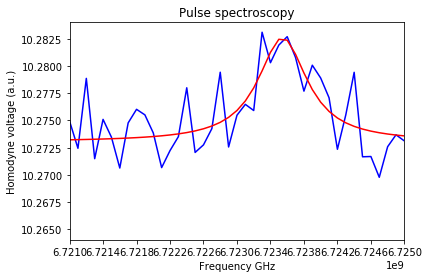

In [53]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
y=data_I2

gmodel = Model(lorentzian)
result = gmodel.fit(y,x=f,amp=1e5,gamma=5e+5, x0=1*6.723e+9,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'b-')
# plt.plot(f, result.init_fit, 'k--') 
plt.plot(f, result.best_fit, 'r-')
plt.xlim(6.723e9-0.002e9, 6.723e9+0.002e9)
plt.title('Pulse spectroscopy')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9, 11))
plt.savefig('pulse_spec_W2-3D_HF_20190314_-45dBm_I2.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 101
    # variables        = 4
    chi-square         = 0.00175681
    reduced chi-square = 1.8111e-05
    Akaike info crit   = -1098.89677
    Bayesian info crit = -1088.43629
[[Variables]]
    x0:      6.7236e+09 +/- 59210.8159 (0.00%) (init = 6.723e+09)
    amp:     27510.0515 +/- 4581.79718 (16.65%) (init = 100000)
    gamma:   976908.678 +/- 197242.638 (20.19%) (init = 500000)
    offset: -4.84468346 +/- 5.8158e-04 (0.01%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, gamma)    =  0.799
    C(amp, offset)   = -0.685
    C(gamma, offset) = -0.526



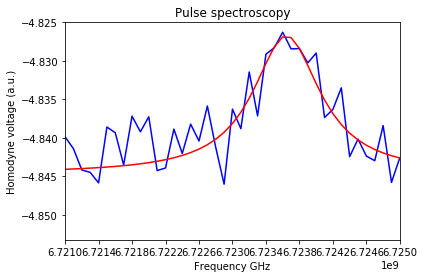

In [54]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
y=data_Q2

gmodel = Model(lorentzian)
result = gmodel.fit(y,x=f,amp=1e5,gamma=5e+5, x0=1*6.723e+9,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'b-')
# plt.plot(f, result.init_fit, 'k--') 
plt.plot(f, result.best_fit, 'r-')
plt.xlim(6.723e9-0.002e9, 6.723e9+0.002e9)
plt.title('Pulse spectroscopy')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9, 11))
plt.savefig('pulse_spec_W2-3D_HF_20190314_-45dBm_Q2.png', dpi=300, bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


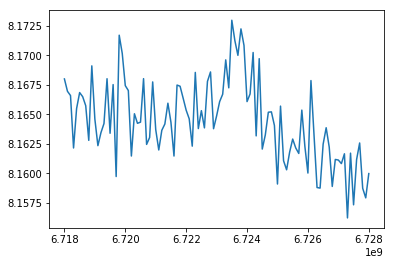

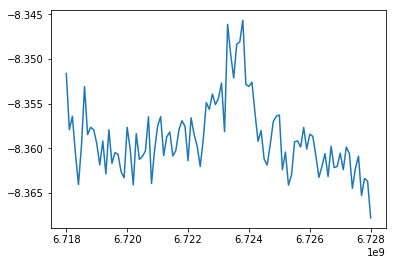

In [258]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(6.723e9-0.005e9, 6.723e9+0.005e9,101)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-45)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(6.158e9)  
length=100

for ii in range(0,length):
    print(ii)
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency.set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(700,500))
#     print(frequency)

integrated_output = np.array(integrated_output) 

data_I3 =np.mean(integrated_output[:,0].reshape(length,101),axis=0)
data_Q3 =np.mean(integrated_output[:,1].reshape(length,101),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I3)
plt.figure()
plt.plot(spec_frequencies, data_Q3)   

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 101
    # variables        = 4
    chi-square         = 8.7839e-04
    reduced chi-square = 9.0555e-06
    Akaike info crit   = -1168.90695
    Bayesian info crit = -1158.44647
[[Variables]]
    x0:      6.7236e+09 +/- 83970.3781 (0.00%) (init = 6.723e+09)
    amp:     10900.5970 +/- 2864.64153 (26.28%) (init = 100000)
    gamma:   838059.943 +/- 272937.492 (32.57%) (init = 500000)
    offset:  8.16346836 +/- 3.9261e-04 (0.00%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, gamma)    =  0.788
    C(amp, offset)   = -0.646
    C(gamma, offset) = -0.491



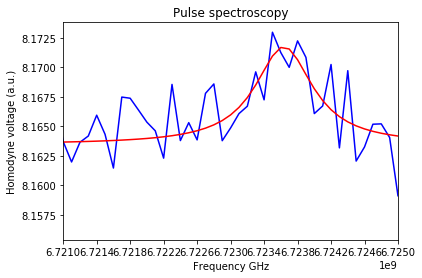

In [259]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
y=data_I3

gmodel = Model(lorentzian)
result = gmodel.fit(y,x=f,amp=1e5,gamma=5e+5, x0=1*6.723e+9,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'b-')
# plt.plot(f, result.init_fit, 'k--') 
plt.plot(f, result.best_fit, 'r-')
plt.xlim(6.723e9-0.002e9, 6.723e9+0.002e9)
plt.title('Pulse spectroscopy')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9, 11))
plt.savefig('pulse_spec_W2-3D_HF_20190316_-45dBm_I3.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 101
    # variables        = 4
    chi-square         = 7.1501e-04
    reduced chi-square = 7.3712e-06
    Akaike info crit   = -1189.69224
    Bayesian info crit = -1179.23176
[[Variables]]
    x0:      6.7236e+09 +/- 55617.2701 (0.00%) (init = 6.723e+09)
    amp:     20976.6059 +/- 3120.28814 (14.88%) (init = 100000)
    gamma:   1055561.20 +/- 187956.905 (17.81%) (init = 500000)
    offset: -8.36074360 +/- 3.8109e-04 (0.00%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, gamma)    =  0.805
    C(amp, offset)   = -0.704
    C(gamma, offset) = -0.544



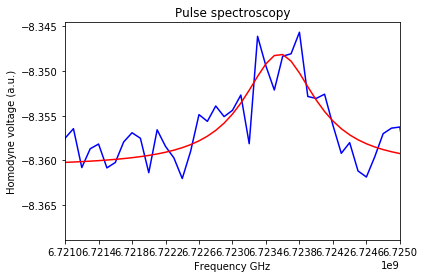

In [262]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
y=data_Q3

gmodel = Model(lorentzian)
result = gmodel.fit(y,x=f,amp=1e5,gamma=5e+5, x0=1*6.723e+9,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'b-')
# plt.plot(f, result.init_fit, 'k--') 
plt.plot(f, result.best_fit, 'r-')
plt.xlim(6.723e9-0.002e9, 6.723e9+0.002e9)
plt.title('Pulse spectroscopy')
plt.xlabel('Frequency GHz')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(6.723e9-0.002e9, 6.723e9+0.002e9, 11))
plt.savefig('pulse_spec_W2-3D_HF_20190316_-45dBm_Q3.png', dpi=300, bbox_inches='tight')

# Rabi Single-element, pulse length 60ns

In [42]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)
rabi_integrated_output = []
SPEC.power.set(-5.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')
for ii in range(0,length):
    print(ii)
    for i, amp in enumerate(amps):
        ATS.clear_buffers()
        AWG.ch1_amp(amp)
        AWG.ch2_amp(amp)
        rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))

rabi_integrated_output = np.array(rabi_integrated_output)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


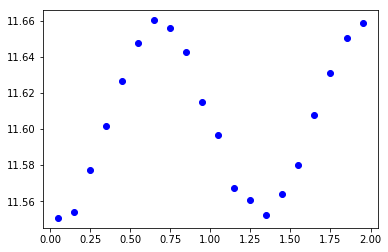

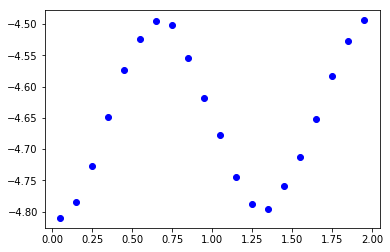

In [43]:
a=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
b=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
# c=np.mean(rabi_integrated_output[:,2].reshape(length,steps),axis=0)
# d=np.mean(rabi_integrated_output[:,3].reshape(length,steps),axis=0)
plt.figure()
plt.plot(amps, a,'bo')
plt.figure()
plt.plot(amps, b,'bo')
# plt.figure()
# plt.plot(amps, c,'bo')
# plt.figure()
# plt.plot(amps, d,'bo')

In [38]:
print(a,b,c,d)
print(amps)

[-1.69514673 -1.68109664 -1.65320717 -1.61794898 -1.57202563 -1.52841311
 -1.48622687 -1.45390953 -1.43795629 -1.43448951 -1.44831843 -1.47348845
 -1.50785735 -1.54557594 -1.58252178 -1.62291478 -1.63842375 -1.65377241
 -1.6446992  -1.6213381 ] [ 1.54920746  1.55483806  1.56006928  1.57043219  1.58473891  1.58611992
  1.60689996  1.61079998  1.61514962  1.61243111  1.61256653  1.60845864
  1.58945782  1.59080091  1.57689839  1.56841731  1.5614202   1.56278229
  1.56355414  1.56738567] [-76.49849202 -76.50083898 -76.49465247 -76.50616817 -76.48826271
 -76.50093593 -76.52554307 -76.5038013  -76.49743684 -76.51700898
 -76.4927254  -76.51074592 -76.49705873 -76.49705268 -76.49390084
 -76.49738495 -76.50374947 -76.48964118 -76.48593943 -76.49099379] [-39.9743753  -39.9666068  -39.96330218 -39.98054554 -39.96526039
 -39.96925884 -39.99275572 -39.96808193 -39.96013166 -39.97731635
 -39.9466639  -39.97622584 -39.95237816 -39.9645426  -39.96586233
 -39.96131574 -39.96314306 -39.96052215 -39.953

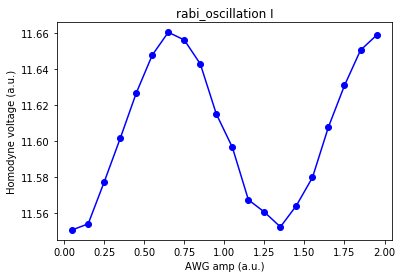

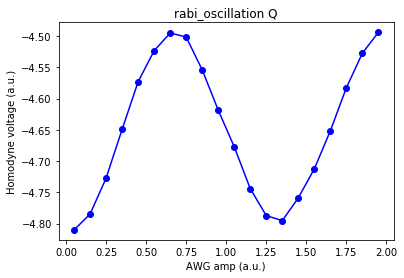

In [93]:
plt.figure()
plt.plot(amps, a,'bo-')
plt.title('rabi_oscillation I')
plt.xlabel('AWG amp (a.u.)')     
plt.ylabel('Homodyne voltage (a.u.)')
plt.savefig('LT130W2-3D_HF_20190314_Rabi_measure_spec-5dBm_60ns_I.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.plot(amps, b,'bo-')
plt.title('rabi_oscillation Q')  
plt.xlabel('AWG amp (a.u.)')     
plt.ylabel('Homodyne voltage (a.u.)')
# plt.xticks(np.arange(6.59e9, 6.595e9, 5e+7))
plt.savefig('LT130W2-3D_HF_20190314_Rabi_measure_spec-5dBm_60ns_Q.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(Rabi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 20
    # variables        = 3
    chi-square         = 4.3556e-04
    reduced chi-square = 2.5621e-05
    Akaike info crit   = -208.692333
    Bayesian info crit = -205.705136
[[Variables]]
    amp:    -0.05411585 +/- 0.00160260 (2.96%) (init = -2)
    omega:   1.32445269 +/- 0.00758936 (0.57%) (init = 1)
    offset:  11.6046749 +/- 0.00117339 (0.01%) (init = 11.51)
[[Correlations]] (unreported correlations are < 0.100)
    C(omega, offset) =  0.264

[[Model]]
    Model(Rabi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 20
    # variables        = 3
    chi-square         = 0.00200307
    reduced chi-square = 1.1783e-04
    Akaike info crit   = -178.176143
    Bayesian info crit = -175.188946
[[Variables]]
    amp:    -0.15278518 +/- 0.00343789 (2.25%) (init = -2)
    omega:   1.32521441 +/- 0.0057

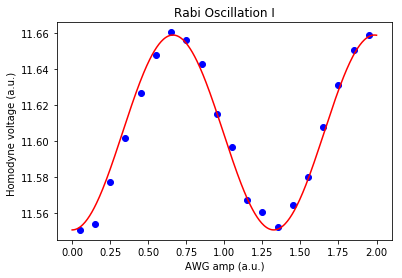

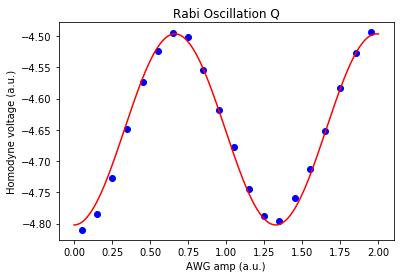

In [98]:
from lmfit import Model 
def Rabi(x,amp,omega,offset):
    return amp*np.cos(2*np.pi*x/omega)+offset

f=amps
y1=a
y2=b

gmodel = Model(Rabi)
result1 = gmodel.fit(y1,x=f,amp=-2,omega=1,offset=11.51)
result2 = gmodel.fit(y2,x=f,amp=-2,omega=1,offset=-4.51)
print(result1.fit_report())
print(result2.fit_report())

plt.figure()
plt.plot(f, y1, 'bo')
plt.plot(f0, Rabi(f0,result1.best_values['amp'],result1.best_values['omega'],result1.best_values['offset']), 'r-')
plt.title('Rabi Oscillation I')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Homodyne voltage (a.u.) ')
plt.savefig('LT130W2-3D_HF_20190314_Rabi_measure_spec-5dBm_60ns_I_fit.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.plot(f, y2, 'bo')
plt.plot(f0, Rabi(f0,result2.best_values['amp'],result2.best_values['omega'],result2.best_values['offset']), 'r-')
plt.title('Rabi Oscillation Q')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Homodyne voltage (a.u.)')
plt.savefig('LT130W2-3D_HF_20190314_Rabi_measure_spec-5dBm_60ns_Q_fit.png', dpi=300, bbox_inches='tight')

In [263]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)
rabi_integrated_output = []
SPEC.power.set(-5.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')
for ii in range(0,length):
    print(ii)
    for i, amp in enumerate(amps):
        ATS.clear_buffers()
        AWG.ch1_amp(amp)
        AWG.ch2_amp(amp)
        rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
#     AWG.set_sequence('rabi_sequence_negative_FILE.seq')
#     for i, amp in enumerate(amps):
#         ATS.clear_buffers()
#         AWG.ch1_amp(amp)
#         AWG.ch2_amp(amp)
#         rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))

rabi_integrated_output = np.array(rabi_integrated_output)

# plt.figure()
# plt.plot(np.linspace(0.1,2,steps), rabi_integrated_output[:,0],'bo' )

# plt.figure()
# plt.plot(np.linspace(0.1,2,steps), rabi_integrated_output[:,1],'bo')

# plt.figure()
# plt.plot(np.linspace(0.1,2,steps), np.sqrt(rabi_integrated_output[:,0]**2+rabi_integrated_output[:,1]**2),'bo')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


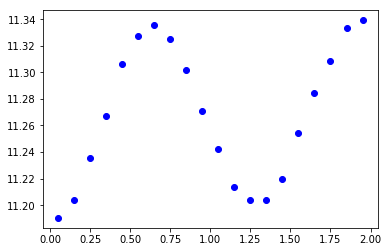

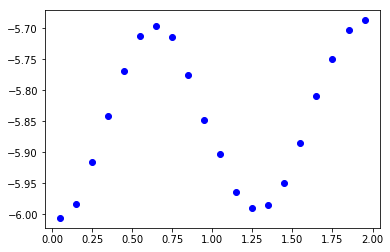

In [264]:
a=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
b=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
# c=np.mean(rabi_integrated_output[:,2].reshape(length,steps),axis=0)
# d=np.mean(rabi_integrated_output[:,3].reshape(length,steps),axis=0)
plt.figure()
plt.plot(amps, a,'bo')
plt.figure()
plt.plot(amps, b,'bo')
# plt.figure()
# plt.plot(amps, c,'bo')
# plt.figure()
# plt.plot(amps, d,'bo')

In [265]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)
rabi_integrated_output = []
SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')
for ii in range(0,length):
    print(ii)
    for i, amp in enumerate(amps):
        ATS.clear_buffers()
        AWG.ch1_amp(amp)
        AWG.ch2_amp(amp)
        rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
#     AWG.set_sequence('rabi_sequence_negative_FILE.seq')
#     for i, amp in enumerate(amps):
#         ATS.clear_buffers()
#         AWG.ch1_amp(amp)
#         AWG.ch2_amp(amp)
#         rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))

rabi_integrated_output = np.array(rabi_integrated_output)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


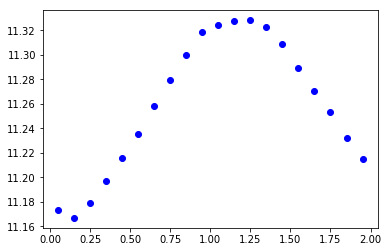

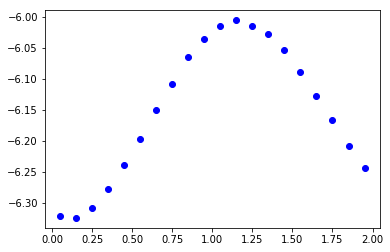

In [266]:
a=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
b=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
# c=np.mean(rabi_integrated_output[:,2].reshape(length,steps),axis=0)
# d=np.mean(rabi_integrated_output[:,3].reshape(length,steps),axis=0)
plt.figure()
plt.plot(amps, a,'bo')
plt.figure()
plt.plot(amps, b,'bo')
# plt.figure()
# plt.plot(amps, c,'bo')
# plt.figure()
# plt.plot(amps, d,'bo')

In [267]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)
rabi_integrated_output = []
SPEC.power.set(-13.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=200
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')
for ii in range(0,length):
    print(ii)
    for i, amp in enumerate(amps):
        ATS.clear_buffers()
        AWG.ch1_amp(amp)
        AWG.ch2_amp(amp)
        rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
#     AWG.set_sequence('rabi_sequence_negative_FILE.seq')
#     for i, amp in enumerate(amps):
#         ATS.clear_buffers()
#         AWG.ch1_amp(amp)
#         AWG.ch2_amp(amp)
#         rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))

rabi_integrated_output = np.array(rabi_integrated_output)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


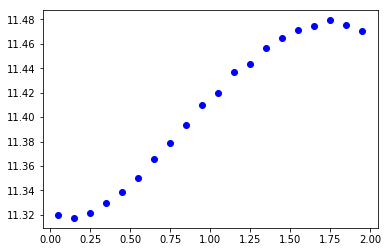

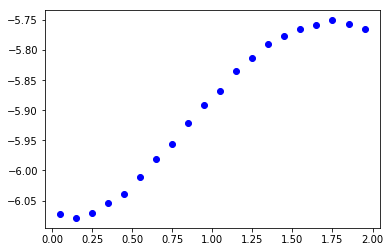

In [268]:
a=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
b=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
# c=np.mean(rabi_integrated_output[:,2].reshape(length,steps),axis=0)
# d=np.mean(rabi_integrated_output[:,3].reshape(length,steps),axis=0)
plt.figure()
plt.plot(amps, a,'bo')
plt.figure()
plt.plot(amps, b,'bo')
# plt.figure()
# plt.plot(amps, c,'bo')
# plt.figure()
# plt.plot(amps, d,'bo')

# Drive Chevron

## First

In [47]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)

chevron_I = []
chevron_Q = []
SPEC.power.set(-5.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.01e9, 6.723e9+0.01e9, 21)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=50
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    rabi_integrated_output = []
    for ii in range(0,length):
        for i, amp in enumerate(amps):
            ATS.clear_buffers()
            AWG.ch1_amp(amp)
            AWG.ch2_amp(amp)
            rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
    rabi_integrated_output = np.array(rabi_integrated_output)
    I=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
    Q=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
    chevron_I.append(I)
    chevron_Q.append(Q)
chevron_I=chevron_I.reshape(len(freqs),steps)
chevron_Q=chevron_Q.reshape(len(freqs),steps)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
plt.figure()
plt.title('Drive chevron I')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(freqs,amp,chevron_I)
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(freqs,amp,chevron_Q)
plt.colorbar()

In [50]:
print(amps)
print(freqs)
print(chevron_I)
print(chevron_Q)

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15
  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95]
[  6.71300000e+09   6.71400000e+09   6.71500000e+09   6.71600000e+09
   6.71700000e+09   6.71800000e+09   6.71900000e+09   6.72000000e+09
   6.72100000e+09   6.72200000e+09   6.72300000e+09   6.72400000e+09
   6.72500000e+09   6.72600000e+09   6.72700000e+09   6.72800000e+09
   6.72900000e+09   6.73000000e+09   6.73100000e+09   6.73200000e+09
   6.73300000e+09]
[array([ 11.67394811,  11.67472414,  11.67775572,  11.69951792,
        11.70926879,  11.71652773,  11.70984742,  11.70172032,
        11.69378125,  11.68224213,  11.68259262,  11.68396743,
        11.6889126 ,  11.69852259,  11.70530007,  11.71496297,
        11.74779066,  11.75203393,  11.75145137,  11.7490859 ]), array([ 11.74198818,  11.74901665,  11.75272958,  11.77494951,
        11.78360668,  11.78463287,  11.78793116,  11.78675549,
        11.76540525,  11.75841481,  11.74598816,  11.75019884,
      

##  Second

In [55]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)

chevron_I2 = []
chevron_Q2 = []
SPEC.power.set(-2.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.01e9, 6.723e9+0.01e9, 21)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=50
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    rabi_integrated_output = []
    for ii in range(0,length):
        for i, amp in enumerate(amps):
            ATS.clear_buffers()
            AWG.ch1_amp(amp)
            AWG.ch2_amp(amp)
            rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
    rabi_integrated_output = np.array(rabi_integrated_output)
    I=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
    Q=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
    chevron_I.append(I)
    chevron_Q.append(Q)
chevron_I2=chevron_I2.reshape(len(freqs),steps)
chevron_Q2=chevron_Q2.reshape(len(freqs),steps)

AttributeError: 'list' object has no attribute 'reshape'

In [182]:
print(amps)
print(freqs)

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15
  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95]
[  6.70300000e+09   6.70500000e+09   6.70700000e+09   6.70900000e+09
   6.71100000e+09   6.71300000e+09   6.71500000e+09   6.71700000e+09
   6.71900000e+09   6.72100000e+09   6.72300000e+09   6.72500000e+09
   6.72700000e+09   6.72900000e+09   6.73100000e+09   6.73300000e+09
   6.73500000e+09   6.73700000e+09   6.73900000e+09   6.74100000e+09
   6.74300000e+09]


In [199]:
chevron_I2=np.array([[ 11.29931158,  11.31589189,  11.34064136,  11.35058585,
        11.35400351,  11.35163173,  11.32172237,  11.31136027,
        11.30632282,  11.32648458,  11.35454168,  11.38518228,
        11.39771088,  11.40379061,  11.38047975,  11.35618157,
        11.34167386,  11.3310879 ,  11.3329259 ,  11.35464825], [ 11.27710625,  11.28484808,  11.31464791,  11.33486095,
        11.33645098,  11.33466207,  11.31966242,  11.29470456,
        11.28309488,  11.29437077,  11.31029852,  11.3387369 ,
        11.37017292,  11.38642926,  11.38735535,  11.36618538,
        11.33786811,  11.31451023,  11.30263931,  11.31042831], [ 11.18297448,  11.20260855,  11.23474861,  11.25759927,
        11.27232498,  11.26332099,  11.23354097,  11.20591608,
        11.19708994,  11.19482754,  11.21653449,  11.25445456,
        11.28199934,  11.30153185,  11.3112563 ,  11.28799461,
        11.26805447,  11.24064371,  11.21643528,  11.21304381], [ 11.13204367,  11.15063203,  11.1854532 ,  11.21781331,
        11.23225998,  11.22475463,  11.19726387,  11.16982223,
        11.14182048,  11.13903706,  11.1682498 ,  11.2013887 ,
        11.23508509,  11.261836  ,  11.26401608,  11.25060868,
        11.22166093,  11.19429212,  11.17326518,  11.15225468], [ 11.09886872,  11.12701047,  11.16157472,  11.19735938,
        11.21954352,  11.20915406,  11.17647177,  11.1448276 ,
        11.12005657,  11.11473133,  11.12629166,  11.16440034,
        11.20418458,  11.23472121,  11.25119206,  11.2327338 ,
        11.20050967,  11.17368267,  11.14444021,  11.12345384], [ 11.02652345,  11.05649178,  11.09288318,  11.12533335,
        11.14885483,  11.15262265,  11.11609144,  11.07853372,
        11.03543052,  11.03008559,  11.04879536,  11.0846672 ,
        11.129191  ,  11.17055794,  11.18566579,  11.16876538,
        11.13865423,  11.1052179 ,  11.06958545,  11.05146067], [ 11.00308891,  11.02411095,  11.06552873,  11.10891634,
        11.13648904,  11.13040966,  11.1012729 ,  11.06439518,
        11.02584547,  11.00809604,  11.02685172,  11.05403545,
        11.09791752,  11.13517209,  11.15385293,  11.14298431,
        11.12078808,  11.08074914,  11.05162912,  11.02768791], [ 10.96963801,  10.98490236,  11.04237162,  11.08124971,
        11.09415201,  11.09895783,  11.07520715,  11.03578348,
        10.99387754,  10.97723316,  10.97610719,  11.01595822,
        11.05387061,  11.09132711,  11.12365065,  11.11911282,
        11.09091066,  11.05723836,  11.02615285,  10.98938807], [ 10.95536903,  10.9821558 ,  11.03202415,  11.08394645,
        11.10781849,  11.11183499,  11.07707966,  11.04029718,
        10.99508881,  10.97417033,  10.98117253,  11.01303791,
        11.05762472,  11.10116125,  11.11367919,  11.1208818 ,
        11.09058159,  11.05378709,  11.01496758,  10.99214751], [ 10.93904898,  10.96532651,  11.01960152,  11.06289463,
        11.09822667,  11.09371931,  11.06409437,  11.02353808,
        10.97156855,  10.95265075,  10.95980265,  10.98211589,
        11.02897945,  11.0701624 ,  11.10088712,  11.10605702,
        11.08634959,  11.04706192,  11.00877993,  10.97814312], [ 10.92900992,  10.96038446,  11.01274872,  11.06106714,
        11.09880515,  11.09882303,  11.06577203,  11.02568297,
        10.98020411,  10.94805824,  10.94971058,  10.97408366,
        11.01823489,  11.06166933,  11.086392  ,  11.10551026,
        11.08663564,  11.05355519,  11.00540875,  10.96837143], [ 10.85274988,  10.88180923,  10.9336438 ,  10.99074776,
        11.02265068,  11.02259177,  10.9992992 ,  10.9489918 ,
        10.89926168,  10.87505673,  10.87243516,  10.89627443,
        10.9392588 ,  10.98299248,  11.01803037,  11.02963741,
        11.02376112,  10.98599255,  10.92949469,  10.90121911], [ 10.78770436,  10.81831392,  10.86684643,  10.91903495,
        10.95703362,  10.95848917,  10.93375366,  10.89126251,
        10.82964347,  10.79827099,  10.7975719 ,  10.82436604,
        10.8726201 ,  10.91490943,  10.95316327,  10.96716938,
        10.94854277,  10.91369578,  10.87322433,  10.83153842], [ 10.73412806,  10.75605641,  10.80306574,  10.85636146,
        10.89667631,  10.90407936,  10.87299103,  10.82975466,
        10.77811211,  10.74696824,  10.74703045,  10.77009444,
        10.81484601,  10.86389502,  10.88936759,  10.91380466,
        10.89420803,  10.86103837,  10.81519396,  10.77375023], [ 10.66609474,  10.69604082,  10.74761158,  10.79903768,
        10.83169478,  10.83716697,  10.81242782,  10.77127337,
        10.71291927,  10.68974803,  10.67621921,  10.70274486,
        10.74232801,  10.80379726,  10.83294131,  10.85697566,
        10.83619401,  10.81018738,  10.76060988,  10.71972628], [ 10.69775867,  10.72995407,  10.77256801,  10.82651359,
        10.86600711,  10.86814888,  10.84205655,  10.80616684,
        10.75199637,  10.72028065,  10.70639123,  10.74131095,
        10.77266291,  10.83297184,  10.86394979,  10.88326645,
        10.87485527,  10.8489531 ,  10.80089099,  10.76358124], [ 10.79908769,  10.82188884,  10.86542838,  10.91303674,
        10.95221505,  10.95020219,  10.92870866,  10.89001698,
        10.84788764,  10.81578401,  10.80538476,  10.83041714,
        10.87154233,  10.92249742,  10.94955615,  10.97863357,
        10.96371448,  10.93483151,  10.89158052,  10.85930917], [ 10.82199731,  10.84854294,  10.88923515,  10.93935064,
        10.96247205,  10.97911273,  10.95624256,  10.91929544,
        10.86586743,  10.83896474,  10.83355183,  10.84824464,
        10.89651857,  10.94211819,  10.97472336,  10.9893887 ,
        10.98913565,  10.95578176,  10.91727719,  10.88033036], [ 10.81006992,  10.83247325,  10.86428942,  10.91485785,
        10.94275137,  10.95165589,  10.92165228,  10.89956091,
        10.84770471,  10.82316305,  10.82212234,  10.83639124,
        10.87177082,  10.91988497,  10.95974214,  10.97933678,
        10.96332945,  10.93463198,  10.89784549,  10.85796345], [ 10.79611115,  10.82527011,  10.85485755,  10.89287591,
        10.92114069,  10.92487055,  10.89887941,  10.8765958 ,
        10.83928915,  10.81600777,  10.80468194,  10.82805485,
        10.86534951,  10.91018165,  10.93344755,  10.94897861,
        10.94613282,  10.92470764,  10.88627815,  10.85305209], [ 10.83867444,  10.86197877,  10.8880589 ,  10.92757284,
        10.94975382,  10.9492634 ,  10.93795257,  10.9166973,
        10.88158666,  10.86155585,  10.85610856,  10.87636713,
        10.90889412,  10.94761822,  10.97624333,  11.00200088,
        10.98611935,  10.96925791,  10.93041658,  10.90086808]])

In [212]:
chevron_Q2=np.array([[-5.99547613, -5.96541421, -5.91861862, -5.87857363, -5.86756354,
       -5.89613637, -5.94612228, -5.97281547, -5.98003451, -5.94143965,
       -5.88133939, -5.8231714 , -5.78880995, -5.78516975, -5.82623231,
       -5.87016578, -5.92216808, -5.94742327, -5.93702991, -5.90153005], [-6.06609077, -6.03129045, -5.97904137, -5.93465922, -5.91589684,
       -5.93626229, -5.98279511, -6.02575918, -6.05265947, -6.03366401,
       -5.99560447, -5.92319192, -5.86594356, -5.83008231, -5.83855159,
       -5.87052137, -5.93184764, -5.98197455, -6.01390762, -6.01324544], [-6.28280078, -6.24421955, -6.18495027, -6.13429643, -6.11070279,
       -6.12683316, -6.18099386, -6.2418416 , -6.26885949, -6.25900642,
       -6.22118049, -6.15037967, -6.08726675, -6.05261944, -6.03442926,
       -6.08240795, -6.12221812, -6.1857957 , -6.22888575, -6.24464769], [-6.44541985, -6.40248863, -6.33848165, -6.26732731, -6.24930664,
       -6.26339436, -6.3124306 , -6.36935774, -6.42408147, -6.41749307,
       -6.38462088, -6.31596374, -6.2517244 , -6.20102708, -6.18371594,
       -6.21085349, -6.27620509, -6.33312745, -6.37559241, -6.3957667 ], [-6.46729364, -6.41031255, -6.34859662, -6.27886944, -6.24892682,
       -6.26587236, -6.31122127, -6.37554298, -6.43672697, -6.43991941,
       -6.41203348, -6.3387199 , -6.26718506, -6.21342784, -6.1911396 ,
       -6.21454026, -6.26787258, -6.33322778, -6.38610524, -6.41245201], [-6.626308  , -6.57594285, -6.51221643, -6.4363143 , -6.39538089,
       -6.40649229, -6.46355862, -6.53478537, -6.58700888, -6.60756556,
       -6.57529559, -6.5119428 , -6.43719269, -6.38289101, -6.35216112,
       -6.37167555, -6.41776638, -6.4964732 , -6.54718648, -6.59033163], [-6.66258372, -6.60536495, -6.5264547 , -6.44140406, -6.39983629,
       -6.39806594, -6.46628266, -6.53494848, -6.60998652, -6.63264677,
       -6.60666858, -6.5326174 , -6.46256303, -6.39264245, -6.35646242,
       -6.37070367, -6.42102346, -6.50077264, -6.56804429, -6.61163834], [-6.70458255, -6.6581281 , -6.57343052, -6.48858441, -6.44338109,
       -6.43408506, -6.49507477, -6.57702156, -6.65718896, -6.68112838,
       -6.66417404, -6.59694401, -6.52668887, -6.44854909, -6.40143013,
       -6.41216313, -6.45732687, -6.52803486, -6.60363546, -6.64991136], [-6.7454788 , -6.68709548, -6.60649749, -6.51965895, -6.46042291,
       -6.46535725, -6.5242998 , -6.60173786, -6.68180322, -6.73077951,
       -6.70729342, -6.6473169 , -6.57153018, -6.48797998, -6.44500495,
       -6.44681792, -6.48292184, -6.56084985, -6.63435551, -6.6885355 ], [-6.73474266, -6.68117858, -6.59249732, -6.49789286, -6.44173454,
       -6.4392707 , -6.50577784, -6.58169901, -6.6624744 , -6.70130877,
       -6.70298191, -6.63882529, -6.56717251, -6.48481956, -6.43497872,
       -6.42430735, -6.46738285, -6.53898145, -6.61241434, -6.67720688], [-6.7262387 , -6.67423974, -6.58522729, -6.49480424, -6.42988619,
       -6.42061251, -6.47520766, -6.55762559, -6.64630553, -6.69852908,
       -6.69983443, -6.647239  , -6.56742838, -6.48125439, -6.42264733,
       -6.40856961, -6.44309274, -6.5126557 , -6.58421819, -6.66276713], [-6.90551768, -6.85821031, -6.76705227, -6.6705662 , -6.61114337,
       -6.61155515, -6.66909027, -6.73773348, -6.83566222, -6.8855687 ,
       -6.88684462, -6.83357988, -6.75081175, -6.67849643, -6.62470539,
       -6.60327425, -6.63270136, -6.69267052, -6.77658326, -6.83706376], [-7.04859016, -6.99894751, -6.90462079, -6.81629155, -6.74702154,
       -6.74330704, -6.79802236, -6.88215388, -6.97276535, -7.02689187,
       -7.0272281 , -6.98634118, -6.90909576, -6.82082094, -6.7601814 ,
       -6.732792  , -6.76669572, -6.82715945, -6.90546705, -6.97358261], [-7.13654471, -7.08857962, -7.01244212, -6.91317531, -6.85132518,
       -6.83598809, -6.89060034, -6.97363375, -7.06370521, -7.11782432,
       -7.11179127, -7.07092082, -6.997696  , -6.92250217, -6.85630691,
       -6.82807881, -6.85660229, -6.91643365, -7.00141397, -7.05864945], [-7.24731708, -7.19570164, -7.10565652, -7.01925818, -6.95240056,
       -6.94731892, -6.99061735, -7.0685006 , -7.15945093, -7.21335669,
       -7.22466824, -7.18376738, -7.10722576, -7.02275867, -6.95362936,
       -6.92953513, -6.95026996, -7.00883092, -7.08921148, -7.15640819], [-7.13478466, -7.08746194, -7.00419296, -6.92134149, -6.85948934,
       -6.84790074, -6.89795982, -6.96538779, -7.05289921, -7.10174053,
       -7.1148575 , -7.07900844, -7.00598914, -6.92619529, -6.86301545,
       -6.82773291, -6.85177213, -6.8907562 , -6.97459295, -7.04706653], [-6.95950994, -6.90725802, -6.8336922 , -6.76022968, -6.70140006,
       -6.6916025 , -6.72533286, -6.78833582, -6.88119517, -6.92761595,
       -6.93434059, -6.90100654, -6.82800877, -6.74635308, -6.68581347,
       -6.64737117, -6.67003669, -6.71680825, -6.79175957, -6.86500454], [-6.90682035, -6.86972245, -6.79982835, -6.71563177, -6.66915367,
       -6.6562381 , -6.69756952, -6.75364477, -6.83201234, -6.88899512,
       -6.89453567, -6.85947801, -6.79472763, -6.72399137, -6.6570254 ,
       -6.61696492, -6.62623398, -6.6758104 , -6.74344943, -6.82265876], [-6.95793349, -6.91622988, -6.85064182, -6.78019489, -6.72558987,
       -6.72393615, -6.76228024, -6.81818888, -6.89327338, -6.93542353,
       -6.93463511, -6.90890265, -6.83761222, -6.7680024 , -6.71207774,
       -6.6684258 , -6.68729118, -6.73184889, -6.79395016, -6.86299415], [-6.89088454, -6.85187584, -6.79758588, -6.72572654, -6.68747502,
       -6.67631488, -6.70366063, -6.76833628, -6.83087123, -6.86812954,
       -6.87284477, -6.83863811, -6.77672793, -6.6992359 , -6.65365152,
       -6.60644915, -6.62514013, -6.65630563, -6.73299459, -6.79777569], [-6.81117641, -6.78489794, -6.72508352, -6.66485924, -6.62124537,
       -6.62357785, -6.65063742, -6.69008933, -6.75905498, -6.79387295,
       -6.79586203, -6.75445087, -6.7029653 , -6.63554736, -6.58265915,
       -6.54190758, -6.54961664, -6.58716738, -6.64981252, -6.71885091]])

In [213]:
chevron_I2_corr=np.zeros((21,20))
chevron_Q2_corr=np.zeros((21,20))

In [214]:
for i in range(len(freqs)):
    chevron_I2_corr[:][i]=chevron_I2[:][i]-chevron_I2[:][i][0]
    chevron_Q2_corr[:][i]=chevron_Q2[:][i]-chevron_Q2[:][i][0]

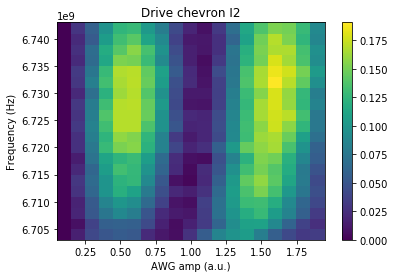

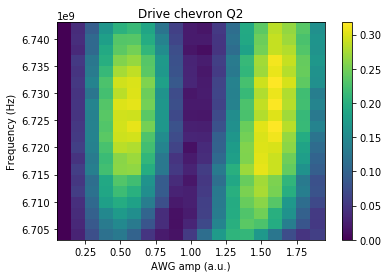

In [215]:
plt.figure()
plt.title('Drive chevron I2')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_I2_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q2')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_Q2_corr)
plt.colorbar()

## Third

In [149]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)

chevron_I3 = []
chevron_Q3 = []
SPEC.power.set(-5.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.02e9, 6.723e9+0.02e9, 21)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=25
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    rabi_integrated_output = []
    for ii in range(0,length):
        for i, amp in enumerate(amps):
            ATS.clear_buffers()
            AWG.ch1_amp(amp)
            AWG.ch2_amp(amp)
            rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
    rabi_integrated_output = np.array(rabi_integrated_output)
    I=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
    Q=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
    chevron_I3.append(I)
    chevron_Q3.append(Q)

In [179]:
print(amps)
print(freqs)

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15
  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95]
[  6.70300000e+09   6.70500000e+09   6.70700000e+09   6.70900000e+09
   6.71100000e+09   6.71300000e+09   6.71500000e+09   6.71700000e+09
   6.71900000e+09   6.72100000e+09   6.72300000e+09   6.72500000e+09
   6.72700000e+09   6.72900000e+09   6.73100000e+09   6.73300000e+09
   6.73500000e+09   6.73700000e+09   6.73900000e+09   6.74100000e+09
   6.74300000e+09]


In [178]:
chevron_I3=np.array([[ 11.26362648,  11.25538248,  11.25508367,  11.25908742,
        11.26259929,  11.26538113,  11.26506857,  11.27116446,
        11.28201891,  11.29410987,  11.32300545,  11.33202385,
        11.34626368,  11.36268827,  11.37623334,  11.37761524,
        11.36949736,  11.35767161,  11.33585365,  11.32558798], [ 11.21274849,  11.20303688,  11.20269416,  11.22009995,
        11.22326606,  11.21621059,  11.22694506,  11.21850507,
        11.22109785,  11.22954822,  11.24712917,  11.26499254,
        11.27653999,  11.28831536,  11.28850939,  11.30239474,
        11.29361695,  11.29112169,  11.27356364,  11.25551303], [ 11.18497396,  11.18681244,  11.20023098,  11.20245349,
        11.20682898,  11.20975183,  11.20735332,  11.20211165,
        11.2007134 ,  11.2049913 ,  11.2150753 ,  11.22305505,
        11.23866449,  11.25265676,  11.25619743,  11.27225399,
        11.2667553 ,  11.25514395,  11.25174431,  11.24915454], [ 11.14031885,  11.14731806,  11.14444273,  11.16658751,
        11.16265295,  11.1737593 ,  11.1701965 ,  11.16277595,
        11.15129285,  11.15701129,  11.16159114,  11.16151856,
        11.17298229,  11.19200213,  11.20642291,  11.2120771 ,
        11.21854729,  11.21911486,  11.20652742,  11.21866044], [ 11.10899315,  11.10369807,  11.11324013,  11.13030589,
        11.13958381,  11.14093883,  11.13542368,  11.14071981,
        11.11008012,  11.10971721,  11.11060717,  11.10917035,
        11.13001508,  11.1383682 ,  11.1623768 ,  11.17519505,
        11.18910758,  11.19302913,  11.18867834,  11.17993917], [ 11.08400769,  11.09631441,  11.1022826 ,  11.12864339,
        11.13663446,  11.14069304,  11.14548022,  11.13699716,
        11.11636701,  11.10473196,  11.09878911,  11.09170182,
        11.10337297,  11.11337604,  11.14388872,  11.16031971,
        11.18457827,  11.18640661,  11.19588255,  11.18320892], [ 11.05677113,  11.07188805,  11.08162006,  11.1071762 ,
        11.13553563,  11.14512642,  11.14135077,  11.12968426,
        11.1119545 ,  11.08464986,  11.07159143,  11.06206451,
        11.06328553,  11.08107073,  11.10227435,  11.13472754,
        11.1604258 ,  11.17367331,  11.18295632,  11.1684994 ], [ 11.04767815,  11.07020641,  11.08039377,  11.10793867,
        11.1392269 ,  11.15560645,  11.16160062,  11.15007621,
        11.1284757 ,  11.09624771,  11.07401243,  11.06234155,
        11.06418831,  11.07830216,  11.09692547,  11.13114001,
        11.15508804,  11.16997793,  11.19695193,  11.17687486], [ 11.06800728,  11.09082507,  11.11934101,  11.14391953,
        11.16941118,  11.18749925,  11.19534191,  11.19277639,
        11.16092116,  11.1368667 ,  11.10745047,  11.08321963,
        11.08868533,  11.08905129,  11.11304314,  11.13528533,
        11.16891886,  11.1946621 ,  11.207516  ,  11.22044968], [ 11.01294283,  11.02716653,  11.04605325,  11.08290121,
        11.12378968,  11.13222759,  11.15264464,  11.13650836,
        11.11981633,  11.08594059,  11.06281217,  11.02764445,
        11.01929758,  11.02355673,  11.05058526,  11.0632866 ,
        11.10596931,  11.12380693,  11.15254927,  11.1609528 ], [ 11.01072695,  11.01995721,  11.05335953,  11.08662225,
        11.12575025,  11.15273957,  11.14324578,  11.15135772,
        11.12508829,  11.10391124,  11.06405142,  11.03214331,
        11.02159013,  11.016004  ,  11.03466284,  11.05955417,
        11.09743636,  11.12666396,  11.13880674,  11.15060203], [ 10.97917905,  10.98826285,  11.01307905,  11.06363383,
        11.09977679,  11.11971183,  11.13075437,  11.1306133 ,
        11.10547801,  11.07022042,  11.0391944 ,  11.00610999,
        10.99190126,  10.99014516,  10.99967639,  11.02426862,
        11.05426021,  11.0878258 ,  11.1183526 ,  11.13837207], [ 10.94102656,  10.95793721,  10.97531791,  11.02240306,
        11.06363742,  11.08038122,  11.09977594,  11.09966618,
        11.07293629,  11.04749612,  11.00461677,  10.98035525,
        10.96267687,  10.96103386,  10.97112003,  10.98519454,
        11.01880716,  11.05012778,  11.0749778 ,  11.11706146], [ 10.93158756,  10.92481009,  10.96926633,  11.01055866,
        11.02763658,  11.0525986 ,  11.07761229,  11.0724754 ,
        11.05039483,  11.01757573,  10.9944774 ,  10.96337096,
        10.94543064,  10.94032373,  10.9425531 ,  10.96467361,
        10.99850996,  11.02746   ,  11.05954238,  11.07853296], [ 10.94141281,  10.94181165,  10.96920222,  10.99768363,
        11.02902734,  11.04513093,  11.06901908,  11.05679524,
        11.03406679,  11.01047373,  10.99636224,  10.96722889,
        10.9413721 ,  10.95026065,  10.95295731,  10.97073647,
        10.99784675,  11.02916032,  11.06910869,  11.08030806], [ 10.93511639,  10.93858003,  10.95446879,  10.98336728,
        11.00913626,  11.02327396,  11.03444364,  11.03537715,
        11.00870113,  11.00627974,  10.98018582,  10.95707654,
        10.94531673,  10.9370515 ,  10.95131293,  10.96294551,
        10.9903315 ,  11.02105817,  11.03259433,  11.0618911 ], [ 10.91097263,  10.91406809,  10.93509817,  10.95676968,
        10.96691609,  10.98646491,  10.98634801,  10.98639665,
        10.97860077,  10.95766716,  10.93339505,  10.92047648,
        10.91588456,  10.91726642,  10.92067597,  10.94626934,
        10.97437401,  10.98714259,  11.01112772,  11.03158092], [ 10.86887011,  10.878503  ,  10.88296907,  10.89513448,
        10.91330128,  10.92484524,  10.93140108,  10.92052979,
        10.91919716,  10.89491288,  10.88823524,  10.87150442,
        10.87741399,  10.86670875,  10.88461134,  10.90700108,
        10.92161177,  10.95218472,  10.96543146,  10.97985754], [ 10.89701238,  10.9071522 ,  10.89839504,  10.91454174,
        10.92755261,  10.93364493,  10.94991782,  10.93448074,
        10.93645599,  10.91965191,  10.92207084,  10.90716958,
        10.91057966,  10.91067128,  10.91272072,  10.94197833,
        10.95512619,  10.97926128,  10.9979762 ,  10.99785886], [ 10.97185477,  10.96694753,  10.97646492,  10.98530847,
        10.99739714,  10.99196563,  10.99758935,  10.9981653 ,
        11.00270102,  10.98452733,  10.98090733,  10.98292826,
        10.97642492,  10.98621609,  10.99381891,  11.00997591,
        11.01498305,  11.03348927,  11.0595578 ,  11.06959774], [ 11.02163933,  11.02065222,  11.01632956,  11.03009078,
        11.03198645,  11.02450431,  11.0279996 ,  11.02586889,
        11.02816869,  11.01996222,  11.01517104,  11.01438137,
        11.02340225,  11.02233004,  11.03934357,  11.04555096,
        11.06935836,  11.07271447,  11.07665841,  11.08777655]])

In [177]:
chevron_Q3=np.array([[-5.84535851, -5.85155185, -5.84836664, -5.84042366, -5.82903903,
       -5.83274794, -5.82042305, -5.80461231, -5.78990104, -5.76332382,
       -5.73546648, -5.70519254, -5.66725216, -5.64008103, -5.62806241,
       -5.62378036, -5.64841191, -5.66057135, -5.69625725, -5.72449955], [-5.97319591, -5.97637017, -5.95923178, -5.94958871, -5.94867515,
       -5.94240805, -5.95027466, -5.95236115, -5.940435  , -5.92681041,
       -5.90666771, -5.86416754, -5.83936295, -5.82345085, -5.80889625,
       -5.78507094, -5.7988892 , -5.8303227 , -5.84487233, -5.87529994], [-5.95723783, -5.94861683, -5.94172965, -5.92840776, -5.9109009 ,
       -5.91824904, -5.92509039, -5.92804529, -5.9302115 , -5.91753441,
       -5.92249517, -5.89020533, -5.86136968, -5.83933701, -5.8212384 ,
       -5.80386831, -5.78978   , -5.79892353, -5.82158809, -5.83790682], [-6.0982709 , -6.09879496, -6.08531948, -6.05683322, -6.05338027,
       -6.04725792, -6.06746987, -6.07652613, -6.09288445, -6.08717891,
       -6.0808465 , -6.07116179, -6.04723275, -6.00819249, -5.97985167,
       -5.94913152, -5.93871241, -5.94445738, -5.9495898 , -5.9692665 ], [-6.17587725, -6.17183611, -6.14906437, -6.11354782, -6.09419257,
       -6.08605971, -6.08862424, -6.11931506, -6.13523404, -6.15428056,
       -6.15034418, -6.15109669, -6.12308462, -6.09197209, -6.04345627,
       -6.01050578, -6.00038122, -5.97880796, -5.99298649, -6.00945113], [-6.23633631, -6.23549094, -6.19367813, -6.15996603, -6.12452154,
       -6.11042567, -6.11550542, -6.13823346, -6.17509009, -6.19660692,
       -6.21512083, -6.21943777, -6.20823228, -6.17765232, -6.12451773,
       -6.0912483 , -6.05060909, -6.03742109, -6.02461667, -6.04845558], [-6.27033109, -6.248481  , -6.21062001, -6.17297038, -6.12053619,
       -6.10244072, -6.09585267, -6.128225  , -6.16483315, -6.20009792,
       -6.23168184, -6.24509286, -6.23760587, -6.20600175, -6.16868483,
       -6.12217368, -6.07212339, -6.03914331, -6.02313725, -6.0321195 ], [-6.2530483 , -6.24369983, -6.19123065, -6.13048288, -6.10031576,
       -6.0691154 , -6.05491271, -6.06161155, -6.11456311, -6.17424552,
       -6.20228571, -6.23525303, -6.24481296, -6.21421418, -6.1709231 ,
       -6.10206785, -6.0622952 , -6.02174576, -5.99835095, -6.0079973 ], [-6.28172038, -6.27103265, -6.2121856 , -6.1470292 , -6.0769923 ,
       -6.0365202 , -6.03532851, -6.05409664, -6.10257759, -6.16497491,
       -6.21519155, -6.25281814, -6.26264759, -6.23877164, -6.20509488,
       -6.14746429, -6.09402528, -6.02997757, -6.0017368 , -5.99032045], [-6.33672024, -6.30338951, -6.24782853, -6.17596831, -6.11370381,
       -6.05804257, -6.04652819, -6.06819343, -6.11243157, -6.17802924,
       -6.23647159, -6.27995864, -6.31846203, -6.30004526, -6.27789729,
       -6.21170041, -6.15398142, -6.08902054, -6.04480302, -6.02943527], [-6.31281051, -6.29217693, -6.23655215, -6.16551078, -6.08214054,
       -6.01687547, -6.01071084, -6.02344205, -6.07825144, -6.14088147,
       -6.19945263, -6.26339521, -6.29496875, -6.30380116, -6.2667047 ,
       -6.2149445 , -6.14492941, -6.08294077, -6.03119571, -5.99871098], [-6.44143511, -6.40845609, -6.348947  , -6.27861464, -6.20729726,
       -6.15497709, -6.12132493, -6.1341071 , -6.1740866 , -6.2379039 ,
       -6.3180379 , -6.38243538, -6.42320735, -6.42875422, -6.3932095 ,
       -6.34676366, -6.27815565, -6.210328  , -6.15581861, -6.1298024 ], [-6.51116394, -6.49092207, -6.44032154, -6.36938297, -6.30167581,
       -6.23603553, -6.21773281, -6.22179354, -6.27919503, -6.33042515,
       -6.37914377, -6.46001447, -6.49993831, -6.50367898, -6.48650559,
       -6.43465017, -6.38112314, -6.30292209, -6.25983409, -6.21205408], [-6.52977523, -6.51300626, -6.44806862, -6.39668086, -6.33297031,
       -6.28336414, -6.23655694, -6.24782533, -6.29050611, -6.34487461,
       -6.40614418, -6.46270897, -6.50556764, -6.5183417 , -6.48922716,
       -6.44929005, -6.39202544, -6.32913824, -6.28462398, -6.24224779], [-6.51191321, -6.48972745, -6.44731112, -6.39796672, -6.33495578,
       -6.29519689, -6.2646222 , -6.27912645, -6.30415196, -6.34244439,
       -6.40475859, -6.45144249, -6.4956615 , -6.50732418, -6.48895001,
       -6.43733592, -6.39163085, -6.3299175 , -6.28580054, -6.2291762 ], [-6.50882465, -6.500948  , -6.46600966, -6.42241706, -6.36866939,
       -6.33213151, -6.30512539, -6.31624841, -6.34102052, -6.3740601 ,
       -6.42325055, -6.46900622, -6.48704466, -6.49466644, -6.4847666 ,
       -6.45010432, -6.39418531, -6.34443782, -6.29461845, -6.24924611], [-6.5630275 , -6.55434211, -6.53092908, -6.48474582, -6.44248711,
       -6.41547885, -6.40889461, -6.42024878, -6.43406573, -6.45334935,
       -6.50554412, -6.53708907, -6.56554517, -6.56055297, -6.53519004,
       -6.50587569, -6.44698903, -6.40158751, -6.3633059 , -6.32291835], [-6.65480101, -6.64698674, -6.63257882, -6.6053985 , -6.56025545,
       -6.56125855, -6.54676116, -6.5507767 , -6.55963426, -6.5988497 ,
       -6.60944313, -6.63830362, -6.63991379, -6.64774301, -6.63259487,
       -6.58901634, -6.55592177, -6.50779252, -6.4746574 , -6.44032147], [-6.5721457 , -6.57389074, -6.54864142, -6.53234165, -6.52054118,
       -6.49563453, -6.49919977, -6.50887595, -6.51451298, -6.53551919,
       -6.54937911, -6.56399253, -6.55784904, -6.55480508, -6.53800208,
       -6.49823524, -6.4723138 , -6.436222  , -6.40518761, -6.3863688 ], [-6.40852557, -6.41107947, -6.39887126, -6.3751713 , -6.37021512,
       -6.36692877, -6.36485176, -6.36815505, -6.37463583, -6.38969777,
       -6.38801415, -6.40946404, -6.3991695 , -6.39679316, -6.37737617,
       -6.34041069, -6.29921837, -6.28611406, -6.25732641, -6.23683476], [-6.31382337, -6.31492076, -6.31559097, -6.30110814, -6.29091249,
       -6.27903634, -6.28160614, -6.28559315, -6.29371998, -6.29655978,
       -6.29907126, -6.29658544, -6.29390779, -6.28685756, -6.27529203,
       -6.2442027 , -6.21804521, -6.19514273, -6.16681691, -6.16711517]])

In [209]:
chevron_I3_corr=np.zeros((21,20))
chevron_Q3_corr=np.zeros((21,20))

In [210]:
for i in range(len(freqs)):
    chevron_I3_corr[:][i]=chevron_I3[:][i]-chevron_I3[:][i][0]
    chevron_Q3_corr[:][i]=chevron_Q3[:][i]-chevron_Q3[:][i][0]


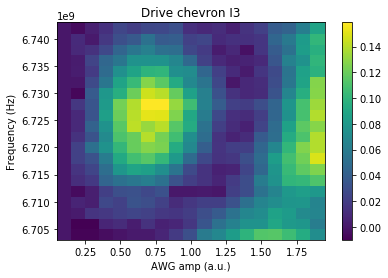

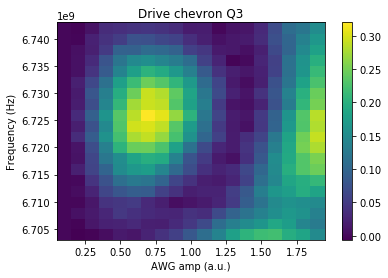

In [211]:
plt.figure()
plt.title('Drive chevron I3')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_I3_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q3')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_Q3_corr)
plt.colorbar()

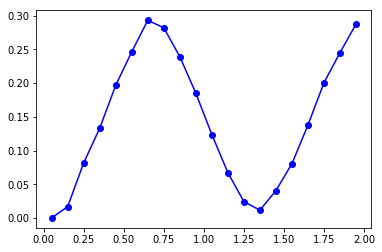

In [191]:
plt.figure()
plt.plot(amps,chevron_Q3_corr[13],'bo-')

## Forth

In [216]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)

chevron_I4 = []
chevron_Q4 = []
SPEC.power.set(-2.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=25
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    rabi_integrated_output = []
    for ii in range(0,length):
        for i, amp in enumerate(amps):
            ATS.clear_buffers()
            AWG.ch1_amp(amp)
            AWG.ch2_amp(amp)
            rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
    rabi_integrated_output = np.array(rabi_integrated_output)
    I=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
    Q=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
    chevron_I4.append(I)
    chevron_Q4.append(Q)

In [218]:
chevron_I4=np.array([[ 11.96982145,  11.97225992,  11.97342778,  11.97969979,
         11.98677476,  11.98675184,  12.00569726,  12.01432221,
         12.03686111,  12.03059998,  12.05190292,  12.03273714,
         12.02923155,  12.02241491,  12.00397166,  11.98738484,
         12.00240468,  12.01812206,  12.04271003,  12.06654555],
 [ 12.02346723,  12.01803141,  12.01387663,  12.02939464,
         12.03792097,  12.04742865,  12.06976404,  12.08991495,
         12.12927982,  12.1312261 ,  12.1310656 ,  12.12810678,
         12.10490665,  12.08956815,  12.0672695 ,  12.04878547,
         12.04734816,  12.05789403,  12.08955158,  12.11683064],
 [ 12.02579037,  12.00701123,  12.01092667,  12.01256209,
         12.03232148,  12.05096623,  12.06985129,  12.10014138,
         12.13200461,  12.16617004,  12.17478276,  12.16539975,
         12.14985487,  12.12162903,  12.08390783,  12.05022537,
         12.03643669,  12.05016112,  12.06500539,  12.10109571],
 [ 12.04643226,  12.02686699,  12.0390023 ,  12.04019014,
         12.06145973,  12.08203246,  12.11534635,  12.16510364,
         12.20392718,  12.23040947,  12.23953614,  12.25055679,
         12.22186298,  12.18890031,  12.1454157 ,  12.09477451,
         12.06779007,  12.0745068 ,  12.09096072,  12.12591646],
 [ 12.02736247,  12.0220273 ,  12.0210836 ,  12.03225995,
         12.05310449,  12.08507566,  12.10899688,  12.1565648 ,
         12.20162547,  12.25529653,  12.26799064,  12.26481254,
         12.2545311 ,  12.19861467,  12.15718746,  12.10921121,
         12.07956745,  12.05743379,  12.05622588,  12.09042125],
 [ 12.04664771,  12.0561672 ,  12.05795459,  12.05544211,
         12.07393394,  12.10389249,  12.15332889,  12.19714394,
         12.24832779,  12.29352073,  12.30345879,  12.30805284,
         12.28594394,  12.24246333,  12.20052408,  12.14729076,
         12.11045701,  12.0812373 ,  12.0934251 ,  12.12395047],
 [ 12.04242479,  12.03079215,  12.03902788,  12.03384396,
         12.06472827,  12.08151346,  12.12861449,  12.15417776,
         12.21960656,  12.25456266,  12.27625381,  12.28556554,
         12.26825594,  12.23524152,  12.18297486,  12.13671054,
         12.09946573,  12.07372635,  12.07808784,  12.10608626],
 [ 12.05663325,  12.06490971,  12.06009367,  12.07152823,
         12.08474869,  12.10887311,  12.13968196,  12.18344965,
         12.22268459,  12.26243861,  12.27561508,  12.28236211,
         12.27194912,  12.24071591,  12.20030977,  12.15253654,
         12.11586839,  12.10152498,  12.11086818,  12.1204131 ],
 [ 12.08686138,  12.09855202,  12.08015054,  12.0819094 ,
         12.10216399,  12.12093668,  12.14535336,  12.17405008,
         12.21146298,  12.23834744,  12.25443219,  12.25736788,
         12.24894662,  12.21909199,  12.18357597,  12.15565532,
         12.12680903,  12.11766062,  12.12791259,  12.14456266],
 [ 12.08030729,  12.07541039,  12.0908065 ,  12.08990971,
         12.08790156,  12.0986046 ,  12.13215812,  12.14399103,
         12.16647275,  12.18688314,  12.2018885 ,  12.19702906,
         12.20994426,  12.1882897 ,  12.15746997,  12.12831939,
         12.10798473,  12.11519636,  12.11232539,  12.14106362],
 [ 12.08697323,  12.093663  ,  12.10106543,  12.08918367,
         12.0945228 ,  12.09915122,  12.09987218,  12.1369297 ,
         12.15161753,  12.17075559,  12.18976218,  12.18493193,
         12.16383579,  12.16785724,  12.14339133,  12.12900574,
         12.12155298,  12.10878044,  12.1334261 ,  12.14026183],
 [ 12.11013502,  12.10745023,  12.10928789,  12.11084125,
         12.11476032,  12.11778267,  12.12068859,  12.12972969,
         12.15080195,  12.16067662,  12.16127106,  12.16815836,
         12.17928552,  12.16922432,  12.14216611,  12.13703559,
         12.13575871,  12.14271639,  12.14137407,  12.16702626],
 [ 12.10704121,  12.10492549,  12.10893483,  12.11311225,
         12.11917992,  12.12142894,  12.10463626,  12.12140241,
         12.12973733,  12.13058809,  12.14703495,  12.15501581,
         12.16705787,  12.1531456 ,  12.14196906,  12.13910523,
         12.12839196,  12.12045435,  12.13458863,  12.14416932],
 [ 12.12979407,  12.13402348,  12.14532813,  12.14978327,
         12.14642376,  12.14869252,  12.1384569 ,  12.14025745,
         12.14009498,  12.15684013,  12.161029  ,  12.17705207,
         12.18443081,  12.18200533,  12.17903675,  12.16300288,
         12.15286079,  12.15860539,  12.15760573,  12.17063588],
 [ 12.13095012,  12.14402544,  12.16065443,  12.15009022,
         12.1534321 ,  12.15558843,  12.14996447,  12.15425696,
         12.14279731,  12.15618618,  12.16441499,  12.18092126,
         12.19165703,  12.19825419,  12.19803434,  12.18480767,
         12.16544235,  12.16727522,  12.165654  ,  12.17363091],
 [ 12.12797893,  12.13875854,  12.14026643,  12.16126841,
         12.16860154,  12.15876626,  12.15042547,  12.13355995,
         12.12726507,  12.12720577,  12.14501246,  12.15569331,
         12.17756383,  12.18721246,  12.17557934,  12.17998379,
         12.16657035,  12.14554985,  12.13741599,  12.14249458],
 [ 12.12890937,  12.14123481,  12.15002052,  12.16905859,
         12.17497576,  12.17399817,  12.15593752,  12.14305428,
         12.13489128,  12.12727583,  12.13754405,  12.16163967,
         12.18147836,  12.20290817,  12.20249245,  12.1953403 ,
         12.18014134,  12.16961699,  12.14178179,  12.14345964],
 [ 12.14765263,  12.16249715,  12.18580209,  12.19778429,
         12.21294406,  12.19549131,  12.19488647,  12.16007004,
         12.15226347,  12.1464113 ,  12.15612203,  12.18429103,
         12.20420462,  12.22300573,  12.22697521,  12.21905121,
         12.21033332,  12.19278581,  12.177521  ,  12.1517361 ],
 [ 12.14776128,  12.17087228,  12.19522894,  12.2218998 ,
         12.23347612,  12.24469986,  12.21861566,  12.18970462,
         12.1772404 ,  12.16625416,  12.1748239 ,  12.1913543 ,
         12.22379352,  12.23141158,  12.24506537,  12.25168207,
         12.23810269,  12.2130052 ,  12.19604812,  12.17907797],
 [ 12.14881369,  12.15633549,  12.19175555,  12.21969681,
         12.23122474,  12.24295451,  12.22279459,  12.20597492,
         12.16233785,  12.15117046,  12.15646658,  12.16337399,
         12.19258135,  12.21988677,  12.23727714,  12.24371708,
         12.23692506,  12.22438525,  12.19187336,  12.17470267],
 [ 12.16330334,  12.17519018,  12.1959536 ,  12.22945454,
         12.24161268,  12.23441527,  12.22707614,  12.21772031,
         12.17734684,  12.17048529,  12.16346022,  12.17441534,
         12.19755934,  12.22517978,  12.24530673,  12.24380101,
         12.23569935,  12.2177907 ,  12.19974322,  12.18801594],
 [ 12.16940242,  12.18013176,  12.21546   ,  12.22922377,
         12.25180201,  12.25339823,  12.2500682 ,  12.22575634,
         12.20347307,  12.18615562,  12.1798818 ,  12.18684953,
         12.21960808,  12.22713482,  12.25243387,  12.27026503,
         12.25594442,  12.23958922,  12.22553131,  12.19226483],
 [ 12.18791903,  12.19996875,  12.22318451,  12.24898095,
         12.26869704,  12.26864591,  12.24678538,  12.23729764,
         12.2098358 ,  12.1988694 ,  12.18589408,  12.19271999,
         12.22266057,  12.25609772,  12.26670902,  12.27522373,
         12.27674634,  12.26166563,  12.24052319,  12.22177473],
 [ 12.21188724,  12.2265999 ,  12.26178964,  12.27769443,
         12.29991541,  12.30987432,  12.30648382,  12.27745021,
         12.24274104,  12.22328631,  12.22291306,  12.23090281,
         12.24642997,  12.278834  ,  12.294932  ,  12.30735928,
         12.30471969,  12.29656261,  12.25803009,  12.25000812],
 [ 12.21141247,  12.22771465,  12.24662814,  12.26808268,
         12.28698301,  12.2919405 ,  12.26952343,  12.25160011,
         12.24958178,  12.22795935,  12.21344328,  12.21772013,
         12.24259845,  12.27595552,  12.28475177,  12.30007473,
         12.29861291,  12.28146466,  12.27866779,  12.25484113],
 [ 12.18009637,  12.19121181,  12.2051038 ,  12.22262336,
         12.2313537 ,  12.24677695,  12.22791034,  12.21438883,
         12.20107311,  12.18199434,  12.19336429,  12.185021  ,
         12.21374432,  12.23334678,  12.25258085,  12.2699627 ,
         12.26001999,  12.24807603,  12.23573078,  12.21486186],
 [ 12.16907064,  12.18564151,  12.18976253,  12.2133643 ,
         12.20987463,  12.21900677,  12.22328323,  12.19991834,
         12.19011647,  12.17607501,  12.17537654,  12.18617327,
         12.20222187,  12.2268494 ,  12.23446867,  12.23372072,
         12.25158747,  12.23527902,  12.22862062,  12.20011587],
 [ 12.17943001,  12.17875884,  12.19898174,  12.20390441,
         12.20215375,  12.2169106 ,  12.21155537,  12.20933291,
         12.19047575,  12.18065197,  12.17760548,  12.19663058,
         12.20324958,  12.22446216,  12.23477397,  12.24242603,
         12.26437036,  12.23831261,  12.22688693,  12.20086175],
 [ 12.18507498,  12.1839119 ,  12.18588683,  12.20896685,
         12.20043307,  12.20363055,  12.20043249,  12.19180984,
         12.19358154,  12.17929866,  12.17972102,  12.18849631,
         12.21464913,  12.21641957,  12.22864692,  12.24595028,
         12.24119664,  12.22586377,  12.20559547,  12.19094092],
 [ 12.18411336,  12.18148681,  12.19027517,  12.19273089,
         12.18731007,  12.1936574 ,  12.1934709 ,  12.19403898,
         12.17770957,  12.1799433 ,  12.18698582,  12.19082157,
         12.20670197,  12.21207414,  12.2244009 ,  12.22477602,
         12.21355761,  12.20774216,  12.19935952,  12.18659962],
 [ 12.17380456,  12.18034017,  12.1813147 ,  12.18590119,
         12.18087935,  12.19014596,  12.17991646,  12.17624497,
         12.16999431,  12.17722676,  12.18297964,  12.19163357,
         12.1943238 ,  12.20001336,  12.21598992,  12.22002505,
         12.21778858,  12.20661567,  12.20015336,  12.18148001],
 [ 12.17262224,  12.17270179,  12.17721729,  12.16903572,
         12.16769457,  12.17789555,  12.17451262,  12.17372707,
         12.17054414,  12.17254802,  12.18204359,  12.1803637 ,
         12.18453665,  12.19473629,  12.19963847,  12.20409865,
         12.19858818,  12.18800475,  12.18895756,  12.17542238],
 [ 12.17445082,  12.16133448,  12.16901205,  12.16074636,
         12.16267208,  12.16499395,  12.16960029,  12.15809774,
         12.16442313,  12.16952237,  12.1779299 ,  12.18587842,
         12.17955827,  12.19324912,  12.20109621,  12.19036546,
         12.19038957,  12.18270528,  12.1750937 ,  12.17737247],
 [ 12.14515567,  12.15972339,  12.16330729,  12.15627608,
         12.16523752,  12.1605051 ,  12.15667158,  12.15887233,
         12.15979737,  12.15622442,  12.16363854,  12.16308155,
         12.17937847,  12.16486483,  12.17199266,  12.17459274,
         12.16842801,  12.16777189,  12.16193937,  12.1539334 ],
 [ 12.14460124,  12.14058116,  12.13427942,  12.14341121,
         12.13773868,  12.14598925,  12.15064527,  12.14639507,
         12.14546703,  12.13827896,  12.13623336,  12.15385056,
         12.15269478,  12.14871821,  12.14694743,  12.15689435,
         12.14593925,  12.14172223,  12.14322619,  12.14360563],
 [ 12.15600334,  12.1531579 ,  12.15425403,  12.1593175 ,
         12.16292323,  12.15525594,  12.16573656,  12.16536331,
         12.16442245,  12.16966906,  12.16932033,  12.16274779,
         12.17116401,  12.17582242,  12.1716637 ,  12.16588086,
         12.16731572,  12.16468746,  12.16475011,  12.15475387],
 [ 12.17012617,  12.17667672,  12.17622918,  12.1679265 ,
         12.16004323,  12.1713934 ,  12.17142723,  12.16884291,
         12.17055582,  12.16780145,  12.17710888,  12.18106116,
         12.1699154 ,  12.16655451,  12.18340236,  12.17520451,
         12.16900304,  12.1701791 ,  12.18316109,  12.17064811],
 [ 12.16495218,  12.16205554,  12.16242857,  12.16028359,
         12.16321365,  12.1662734 ,  12.16670371,  12.16067213,
         12.16025124,  12.16954061,  12.1746274 ,  12.17378829,
         12.1714383 ,  12.16315887,  12.17401775,  12.16229934,
         12.16369785,  12.1688865 ,  12.15969562,  12.16838724],
 [ 12.12981175,  12.13241307,  12.12571519,  12.1259369 ,
         12.13187062,  12.131724  ,  12.14341458,  12.13291518,
         12.14196092,  12.13203137,  12.13667947,  12.13724247,
         12.13672141,  12.13583425,  12.1315826 ,  12.14273185,
         12.13608036,  12.12508507,  12.14528886,  12.14688023],
 [ 12.14435867,  12.14853922,  12.14085981,  12.149288  ,
         12.14194389,  12.14684131,  12.13666467,  12.14159588,
         12.13454955,  12.14397268,  12.14135367,  12.15203465,
         12.14606096,  12.1529353 ,  12.15340068,  12.14834933,
         12.14003422,  12.14365195,  12.14873252,  12.14942992],
 [ 12.09496127,  12.10044338,  12.10887707,  12.09180651,
         12.0966043 ,  12.10103946,  12.09715863,  12.09638459,
         12.09983769,  12.09266323,  12.10501483,  12.10397822,
         12.10840633,  12.10478286,  12.09158157,  12.10064641,
         12.10513633,  12.09858876,  12.11112541,  12.11273176]])

In [221]:
chevron_Q4=np.array([[-4.26097642, -4.25872255, -4.26433425, -4.24839194, -4.23985824,
        -4.22289113, -4.17835187, -4.15762381, -4.11569199, -4.09549994,
        -4.09173122, -4.10281473, -4.13302455, -4.17448295, -4.19259415,
        -4.20654265, -4.19370392, -4.1611378 , -4.10127575, -4.0344209 ],
 [-4.17948761, -4.19882018, -4.1923526 , -4.1851258 , -4.16289245,
        -4.14650843, -4.08929537, -4.0441554 , -3.97281083, -3.95501585,
        -3.93773133, -3.94286587, -3.98019137, -4.0405474 , -4.09286238,
        -4.11412964, -4.13975169, -4.10140773, -4.04722925, -3.97418868],
 [-4.1654117 , -4.19877474, -4.19375824, -4.1566949 , -4.14306555,
        -4.10143417, -4.03497021, -3.96297296, -3.89330449, -3.84120956,
        -3.80876779, -3.82329837, -3.87114071, -3.93720498, -4.00399363,
        -4.07277359, -4.11580177, -4.09052157, -4.05152304, -3.96508622],
 [-4.132218  , -4.150397  , -4.14868872, -4.13498815, -4.09923629,
        -4.04552795, -3.95740596, -3.86062675, -3.76840761, -3.70000619,
        -3.67298658, -3.67376331, -3.71788143, -3.80965879, -3.90068092,
        -4.00834482, -4.06370239, -4.07307369, -4.03326666, -3.94754928],
 [-4.17551979, -4.19341769, -4.18188933, -4.16891856, -4.13646403,
        -4.07098744, -3.97176901, -3.87468975, -3.76973409, -3.67767081,
        -3.61595345, -3.61636792, -3.66094952, -3.76698653, -3.88026038,
        -3.99443413, -4.07483443, -4.10440169, -4.08070614, -3.99603914],
 [-4.09698879, -4.1275887 , -4.12861671, -4.0988927 , -4.06977443,
        -4.00026678, -3.89508144, -3.80080608, -3.67064724, -3.579166  ,
        -3.53261844, -3.5258965 , -3.56594801, -3.65289342, -3.77678679,
        -3.90036749, -3.98781529, -4.02447673, -4.01634964, -3.9490363 ],
 [-4.07054928, -4.07661256, -4.07434941, -4.06600732, -4.02517673,
        -3.96556108, -3.85463897, -3.76567429, -3.64795979, -3.56192438,
        -3.49809725, -3.49988226, -3.5465975 , -3.61851285, -3.72601632,
        -3.84638381, -3.93819123, -3.97195441, -3.96568913, -3.91114266],
 [-3.98555306, -3.99763033, -3.99285408, -3.98717047, -3.95390718,
        -3.91006043, -3.82159358, -3.73322461, -3.63391657, -3.56333494,
        -3.5057552 , -3.50403748, -3.53264553, -3.60407971, -3.69710466,
        -3.78633298, -3.87213781, -3.91245831, -3.90050338, -3.83830367],
 [-3.94305055, -3.93226078, -3.94197553, -3.93192677, -3.89770269,
        -3.85889318, -3.79758971, -3.73961695, -3.63794125, -3.58426764,
        -3.5449194 , -3.53163044, -3.56307353, -3.61359769, -3.68786375,
        -3.77169671, -3.82484499, -3.856612  , -3.82674793, -3.77124181],
 [-3.9026694 , -3.92273649, -3.91098005, -3.89982912, -3.88453529,
        -3.86751109, -3.81675   , -3.7703306 , -3.70497219, -3.65256974,
        -3.62020325, -3.60513302, -3.61765164, -3.66975576, -3.72948388,
        -3.80028613, -3.83700453, -3.84677854, -3.81771507, -3.77091792],
 [-3.97424137, -3.97708702, -3.97120645, -3.95703061, -3.95589967,
        -3.93408477, -3.92591002, -3.89716108, -3.8309392 , -3.78500955,
        -3.76246748, -3.74975332, -3.76857652, -3.79002285, -3.83958093,
        -3.89014007, -3.91902173, -3.93193917, -3.90230825, -3.83873822],
 [-3.87220412, -3.87273998, -3.860329  , -3.84948824, -3.85329101,
        -3.85494899, -3.84822672, -3.84100099, -3.78427562, -3.75345518,
        -3.71070631, -3.69690981, -3.69898348, -3.72841474, -3.76031567,
        -3.80471594, -3.81544951, -3.81858949, -3.79323284, -3.74100041],
 [-3.8697383 , -3.86887414, -3.85698617, -3.84199006, -3.84143415,
        -3.83684398, -3.85665019, -3.85101371, -3.81965377, -3.7782972 ,
        -3.74097028, -3.71920723, -3.71144625, -3.71606637, -3.74019223,
        -3.77378007, -3.79793085, -3.82932218, -3.79730487, -3.76301316],
 [-3.82213816, -3.80957463, -3.77887412, -3.75758918, -3.75285033,
        -3.77203486, -3.78634701, -3.80719611, -3.79692577, -3.75253979,
        -3.70923629, -3.65714042, -3.64154557, -3.63750472, -3.65659872,
        -3.69429438, -3.7327376 , -3.76652334, -3.75492062, -3.71909808],
 [-3.85533762, -3.8311978 , -3.80458091, -3.78067709, -3.77193475,
        -3.78992758, -3.8121724 , -3.84158818, -3.84274568, -3.81693216,
        -3.77283829, -3.72127174, -3.67695893, -3.66123834, -3.67317413,
        -3.71490014, -3.75867439, -3.78509906, -3.79879046, -3.78042373],
 [-3.90436327, -3.86818551, -3.81550083, -3.77006217, -3.75435413,
        -3.77118   , -3.81327648, -3.85767257, -3.87956951, -3.86429653,
        -3.81984248, -3.75528688, -3.70263754, -3.67405062, -3.67158314,
        -3.69857773, -3.74289471, -3.80438924, -3.83932052, -3.84530108],
 [-3.86964972, -3.83559398, -3.76876792, -3.70772612, -3.68892168,
        -3.69908674, -3.74982149, -3.80586205, -3.83940509, -3.84411903,
        -3.80833412, -3.72644053, -3.66707773, -3.62269619, -3.60698454,
        -3.638607  , -3.67852493, -3.74367163, -3.79066287, -3.81917919],
 [-3.77231491, -3.71725422, -3.64126845, -3.58425594, -3.54830083,
        -3.5461415 , -3.60119687, -3.66300186, -3.72950082, -3.74778181,
        -3.70857226, -3.64262077, -3.55792584, -3.50233954, -3.47365327,
        -3.49206561, -3.53654536, -3.61256698, -3.67103567, -3.70797245],
 [-3.77778003, -3.70770784, -3.63452616, -3.54769994, -3.50278997,
        -3.50413713, -3.56244159, -3.6512046 , -3.7136578 , -3.75608809,
        -3.73104802, -3.66527885, -3.58547179, -3.50244434, -3.46609476,
        -3.46545138, -3.51797555, -3.58536358, -3.66503711, -3.71510926],
 [-3.78254861, -3.71739848, -3.62947512, -3.54687464, -3.48986662,
        -3.48476334, -3.52893988, -3.62650489, -3.72524517, -3.7501351 ,
        -3.75976423, -3.69517491, -3.61224539, -3.52574843, -3.46780354,
        -3.46826816, -3.49528387, -3.56655336, -3.64344764, -3.70530148],
 [-3.78910685, -3.7293262 , -3.63138613, -3.52995732, -3.45610894,
        -3.4655655 , -3.51669449, -3.60078987, -3.69632304, -3.75056529,
        -3.75132548, -3.70827852, -3.61382494, -3.53435334, -3.4656276 ,
        -3.4457697 , -3.48229741, -3.536504  , -3.62782627, -3.70249021],
 [-3.72429948, -3.6609014 , -3.56626133, -3.46401641, -3.39836584,
        -3.37912258, -3.43798402, -3.52144329, -3.6200429 , -3.68271359,
        -3.69957409, -3.65636741, -3.5766111 , -3.48191377, -3.40299554,
        -3.36842013, -3.38827605, -3.45174168, -3.54299977, -3.59907754],
 [-3.64094927, -3.58010773, -3.48993938, -3.38963441, -3.32889013,
        -3.30353548, -3.3581718 , -3.45089992, -3.54035184, -3.59410811,
        -3.61012437, -3.57001713, -3.49130967, -3.40703367, -3.32867125,
        -3.28168929, -3.29240397, -3.34760403, -3.42950568, -3.5101794 ],
 [-3.59981195, -3.5374137 , -3.44701412, -3.36247486, -3.29548356,
        -3.28035813, -3.32930163, -3.38441847, -3.47964099, -3.54109746,
        -3.56036395, -3.53974832, -3.4584397 , -3.37691536, -3.31524569,
        -3.27495325, -3.28000863, -3.3119775 , -3.39399556, -3.47842494],
 [-3.62615988, -3.59291584, -3.52509442, -3.44266799, -3.38376352,
        -3.37771211, -3.41291852, -3.47588993, -3.54434727, -3.59234829,
        -3.61492718, -3.58703096, -3.51773592, -3.44354752, -3.38178464,
        -3.32291179, -3.31838381, -3.36546558, -3.43480863, -3.51269841],
 [-3.72568726, -3.69265804, -3.62346129, -3.57345139, -3.5153393 ,
        -3.51294883, -3.54804455, -3.60611598, -3.66521731, -3.70313929,
        -3.71014248, -3.6836967 , -3.62618464, -3.54836629, -3.48192559,
        -3.42257398, -3.44094541, -3.46584089, -3.53265993, -3.59901786],
 [-3.71813999, -3.68685406, -3.63966417, -3.58877184, -3.54799522,
        -3.54465051, -3.56595922, -3.60966919, -3.65880481, -3.68348163,
        -3.68836134, -3.67312764, -3.6078544 , -3.54716796, -3.49219864,
        -3.44415372, -3.44370829, -3.48535053, -3.52664349, -3.59755991],
 [-3.66459752, -3.64111321, -3.61304988, -3.58306033, -3.55320292,
        -3.5438229 , -3.56419206, -3.59845699, -3.6351508 , -3.656118  ,
        -3.64465964, -3.59827185, -3.56521371, -3.5037726 , -3.46607178,
        -3.42595782, -3.42173729, -3.46666509, -3.51458842, -3.57094216],
 [-3.65884325, -3.64580576, -3.61427671, -3.59224485, -3.57364862,
        -3.57523775, -3.5880046 , -3.61739726, -3.62412699, -3.64706866,
        -3.64096476, -3.61130229, -3.56334002, -3.50311449, -3.47075398,
        -3.44642513, -3.4547952 , -3.48619573, -3.52652402, -3.57954764],
 [-3.69210353, -3.67829928, -3.66338848, -3.65570077, -3.65094558,
        -3.64210847, -3.64077042, -3.65671765, -3.67472232, -3.67840185,
        -3.66016337, -3.63863141, -3.59075291, -3.55538277, -3.52206482,
        -3.50384229, -3.51075545, -3.54975509, -3.57649211, -3.61444728],
 [-3.69171711, -3.68291081, -3.67186149, -3.66100283, -3.6554481 ,
        -3.66549644, -3.65695945, -3.67033813, -3.6799816 , -3.67712552,
        -3.65650461, -3.62980931, -3.59185632, -3.56302257, -3.53699634,
        -3.52285658, -3.55402974, -3.56218154, -3.59932704, -3.6477495 ],
 [-3.65579158, -3.64700327, -3.64666005, -3.64875933, -3.63713701,
        -3.64139137, -3.64228543, -3.65266012, -3.649009  , -3.64764527,
        -3.63338193, -3.60516265, -3.57927702, -3.54289277, -3.52983626,
        -3.53244618, -3.55186982, -3.56252713, -3.59481689, -3.61021926],
 [-3.72459805, -3.73177204, -3.73264977, -3.71543826, -3.71893994,
        -3.72618863, -3.72312701, -3.72518802, -3.7251582 , -3.70929978,
        -3.69847554, -3.67697945, -3.65980731, -3.64856904, -3.63895265,
        -3.64088388, -3.65286188, -3.67418542, -3.68344396, -3.71408677],
 [-3.78695989, -3.79367265, -3.78422919, -3.78280826, -3.78906811,
        -3.77774395, -3.78955366, -3.78171676, -3.79078174, -3.78658798,
        -3.76800345, -3.75084674, -3.73682573, -3.72829879, -3.72968286,
        -3.72841497, -3.73327297, -3.74555615, -3.75904152, -3.77104198],
 [-3.80331985, -3.80265202, -3.80304097, -3.80178861, -3.80004932,
        -3.79293185, -3.81037564, -3.79993918, -3.80267597, -3.79031764,
        -3.78261575, -3.77461178, -3.75900777, -3.76110024, -3.75922607,
        -3.76441428, -3.76794695, -3.7811963 , -3.78462527, -3.8010927 ],
 [-3.79416362, -3.78514823, -3.79455763, -3.8005353 , -3.79875899,
        -3.79596491, -3.79217451, -3.79040396, -3.78794737, -3.78146818,
        -3.77344056, -3.77407122, -3.76358485, -3.76215457, -3.76330928,
        -3.76772434, -3.77711778, -3.77931178, -3.78202672, -3.78636451],
 [-3.80589374, -3.80048218, -3.7988444 , -3.80235365, -3.80553641,
        -3.80145994, -3.79233827, -3.80219496, -3.79488749, -3.79297495,
        -3.78876248, -3.76920416, -3.77049898, -3.77703403, -3.77394   ,
        -3.77721425, -3.79101594, -3.78587656, -3.78769407, -3.79244786],
 [-3.85983485, -3.86111963, -3.85294581, -3.85997891, -3.8598931 ,
        -3.86036624, -3.85184738, -3.8509503 , -3.85553631, -3.8452196 ,
        -3.84044381, -3.84759773, -3.84496529, -3.84021032, -3.84487372,
        -3.84005528, -3.85507022, -3.85155744, -3.85048456, -3.84953389],
 [-3.89790518, -3.89110885, -3.90345687, -3.90001971, -3.8925133 ,
        -3.90967645, -3.89652579, -3.89156144, -3.90006559, -3.8987232 ,
        -3.88321824, -3.88342477, -3.89423837, -3.89748616, -3.89619301,
        -3.89330193, -3.89581049, -3.89739122, -3.90562573, -3.88378581],
 [-3.96256968, -3.96013349, -3.95386182, -3.96370247, -3.96408807,
        -3.9458996 , -3.95399789, -3.94953372, -3.95062432, -3.96536889,
        -3.9526996 , -3.94714776, -3.96094547, -3.96042317, -3.95161847,
        -3.95923527, -3.96150016, -3.95461055, -3.95343706, -3.95273002],
 [-4.09771227, -4.09594291, -4.08580277, -4.09151005, -4.10410335,
        -4.09735794, -4.0994995 , -4.09209062, -4.09955439, -4.10685736,
        -4.0994048 , -4.10111271, -4.09267079, -4.09337116, -4.09566612,
        -4.099438  , -4.09470806, -4.10184854, -4.09410996, -4.08783284]])


In [225]:
chevron_I4_corr=np.zeros((41,20))
chevron_Q4_corr=np.zeros((41,20))

In [226]:
for i in range(len(freqs)):
    chevron_I4_corr[:][i]=chevron_I4[:][i]-chevron_I4[:][i][0]
    chevron_Q4_corr[:][i]=chevron_Q4[:][i]-chevron_Q4[:][i][0]


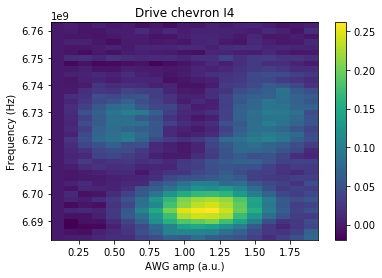

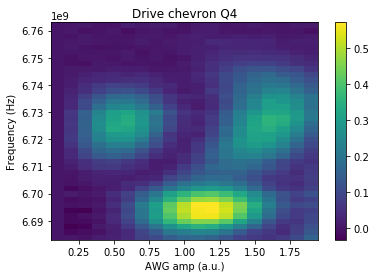

In [227]:
plt.figure()
plt.title('Drive chevron I4')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_I4_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q4')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_Q4_corr)
plt.colorbar()

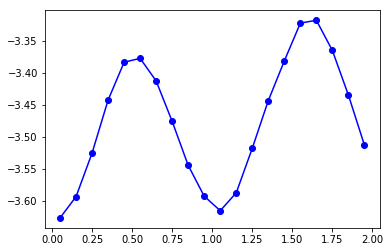

In [251]:
plt.figure()
plt.plot(amps,chevron_Q4[24],'bo-')

## fifth chevron

In [269]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)

chevron_I5 = []
chevron_Q5 = []
SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=25
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    rabi_integrated_output = []
    for ii in range(0,length):
        for i, amp in enumerate(amps):
            ATS.clear_buffers()
            AWG.ch1_amp(amp)
            AWG.ch2_amp(amp)
            rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
    rabi_integrated_output = np.array(rabi_integrated_output)
    I=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
    Q=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
    chevron_I5.append(I)
    chevron_Q5.append(Q)

In [289]:
chevron_I5_corr=np.zeros((41,20))
chevron_Q5_corr=np.zeros((41,20))
for i in range(len(freqs)):
    chevron_I5_corr[:][i]=chevron_I5[:][i]-chevron_I5[:][i][0]
    chevron_Q5_corr[:][i]=chevron_Q5[:][i]-chevron_Q5[:][i][0]
    

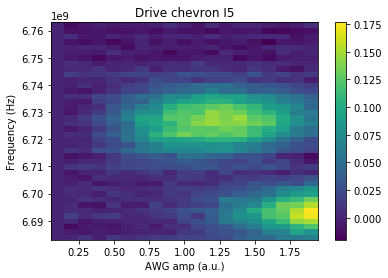

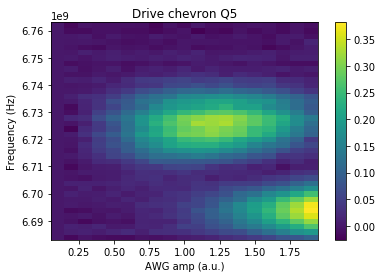

In [291]:
plt.figure()
plt.title('Drive chevron I5')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_I5_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q5')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_Q5_corr)
plt.colorbar()

In [276]:
AWG.set_sequence('rabi_sequence_FILE.seq')
amps = np.arange(0.05,2.0,0.1)
steps=len(amps)

chevron_I6 = []
chevron_Q6 = []
SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.7236e9-0.001e9, 6.723e9+0.001e9, 21)
RFLO.on()
RFLO.power(13.0)  
RFLO.frequency.set(6.158e9)  
length=25
# AWG.set_sequence('rabi_sequence_FILE.seq')
# AWG.set_sequence('rabi_sequence_negative_FILE.seq')

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    rabi_integrated_output = []
    for ii in range(0,length):
        for i, amp in enumerate(amps):
            ATS.clear_buffers()
            AWG.ch1_amp(amp)
            AWG.ch2_amp(amp)
            rabi_integrated_output.append(ATS_homodyne_acquisition(800,500))
    rabi_integrated_output = np.array(rabi_integrated_output)
    I=np.mean(rabi_integrated_output[:,0].reshape(length,steps),axis=0)
    Q=np.mean(rabi_integrated_output[:,1].reshape(length,steps),axis=0)
    chevron_I6.append(I)
    chevron_Q6.append(Q)

In [300]:
chevron_Q6=np.array([[-7.71620551, -7.70663452, -7.69304272, -7.65755067, -7.62448581,
        -7.59537948, -7.54214073, -7.50652683, -7.47689447, -7.44751407,
        -7.43017388, -7.42617657, -7.43043521, -7.44910518, -7.47308638,
        -7.50920778, -7.54080994, -7.57697863, -7.61635967, -7.6507685 ],
 [-7.68690993, -7.69903106, -7.67116711, -7.65759513, -7.61474056,
        -7.57596952, -7.52669967, -7.49564892, -7.45318327, -7.42777224,
        -7.41070743, -7.40456045, -7.40880396, -7.41768611, -7.4513305 ,
        -7.49110501, -7.52678561, -7.56581661, -7.59198484, -7.63761187],
 [-7.77001961, -7.76804881, -7.74577345, -7.71320985, -7.68605483,
        -7.63290672, -7.59809475, -7.55789518, -7.51749722, -7.49840106,
        -7.47775468, -7.46465237, -7.48068329, -7.49607693, -7.5060034 ,
        -7.55187671, -7.59015965, -7.63680514, -7.67340608, -7.70605759],
 [-7.81986453, -7.81387042, -7.79610908, -7.7504727 , -7.73422157,
        -7.68513958, -7.6424724 , -7.60189248, -7.56964533, -7.53599106,
        -7.52695505, -7.51492476, -7.51630199, -7.55013098, -7.57493828,
        -7.59092351, -7.63691746, -7.6791824 , -7.71745147, -7.74329003],
 [-7.75583577, -7.74987008, -7.73229834, -7.69823232, -7.66498594,
        -7.6313212 , -7.58437871, -7.54004905, -7.51516235, -7.47689643,
        -7.47649743, -7.4659062 , -7.48180142, -7.49247797, -7.52014177,
        -7.53767812, -7.57435149, -7.6260344 , -7.65917588, -7.67913236],
 [-7.73572891, -7.71344785, -7.70301526, -7.67218915, -7.63484355,
        -7.60184006, -7.56273939, -7.52150542, -7.48084809, -7.45334541,
        -7.44029109, -7.43598402, -7.44318954, -7.46324122, -7.47028969,
        -7.50779088, -7.54875833, -7.58452969, -7.62980361, -7.65333944],
 [-7.73196125, -7.74581927, -7.71864743, -7.69962013, -7.65180023,
        -7.60889958, -7.57015534, -7.52925842, -7.49380531, -7.46242828,
        -7.44701713, -7.44291847, -7.44835966, -7.45851982, -7.4842918 ,
        -7.51581498, -7.55639054, -7.59215698, -7.63246762, -7.65702466],
 [-7.76297427, -7.7574097 , -7.74195658, -7.71482935, -7.67952223,
        -7.62924748, -7.5876734 , -7.54681667, -7.50815419, -7.4917868 ,
        -7.46274323, -7.45876348, -7.47537676, -7.49256348, -7.51286675,
        -7.54294107, -7.5863265 , -7.62443031, -7.64513255, -7.68318447],
[-7.82951492, -7.83100148, -7.80969604, -7.79546445, -7.75938099,
        -7.71132375, -7.65731157, -7.63418675, -7.5995707 , -7.57210365,
        -7.54854169, -7.54735284, -7.55118529, -7.56204752, -7.59777842,
        -7.62929616, -7.67193442, -7.70087798, -7.73850564, -7.77723198],
 [-7.83534663, -7.83929926, -7.82016054, -7.78724171, -7.73460396,
        -7.71208629, -7.65900991, -7.62511181, -7.59301427, -7.56626807,
        -7.54592346, -7.53382875, -7.5491852 , -7.55950384, -7.58556216,
        -7.60850369, -7.6614946 , -7.69067836, -7.72904004, -7.75911431],
 [-7.79987642, -7.79668625, -7.77799578, -7.7510716 , -7.71228863,
        -7.66067761, -7.62236733, -7.58624805, -7.54298883, -7.52169749,
        -7.50070096, -7.5030379 , -7.50543946, -7.51797394, -7.53948107,
        -7.5723451 , -7.60831457, -7.64616768, -7.68732594, -7.71422896],
 [-7.74932653, -7.74706017, -7.72891052, -7.68688794, -7.65107326,
        -7.60601688, -7.57331998, -7.53073158, -7.48874006, -7.45591384,
        -7.45268468, -7.44884619, -7.45136192, -7.458289  , -7.49482247,
        -7.52885592, -7.56432097, -7.60084617, -7.63060623, -7.67260392],
 [-7.86794245, -7.88008589, -7.86140843, -7.83835546, -7.78840099,
        -7.75290403, -7.70867421, -7.67059186, -7.62988082, -7.60289006,
        -7.5828275 , -7.58414426, -7.58706071, -7.60223824, -7.62977695,
        -7.65773995, -7.70552158, -7.73826687, -7.78138747, -7.82594409],
 [-7.97547304, -7.96863114, -7.95671069, -7.92267306, -7.8823779 ,
        -7.8472704 , -7.80482113, -7.76081998, -7.72307427, -7.69539936,
        -7.68082833, -7.67191195, -7.68332357, -7.68976556, -7.71520897,
        -7.75456186, -7.79429713, -7.8332104 , -7.85961613, -7.89249233],
 [-7.98530618, -7.97930532, -7.97331437, -7.93787265, -7.89971777,
        -7.86499075, -7.82181032, -7.78452745, -7.73955553, -7.7133696 ,
        -7.69419883, -7.69559622, -7.70147388, -7.72468979, -7.74200184,
        -7.76487481, -7.80687902, -7.85250646, -7.88736993, -7.90804334],
 [-7.94280947, -7.95321749, -7.92998932, -7.89807365, -7.86868215,
        -7.82318914, -7.77163754, -7.73309002, -7.70099661, -7.67663156,
        -7.66754755, -7.65586529, -7.65228851, -7.67688747, -7.70580081,
        -7.72537112, -7.75182093, -7.79255388, -7.84263974, -7.86751686],
 [-7.97384068, -7.97685212, -7.96756572, -7.92977385, -7.89279227,
        -7.8501207 , -7.80404215, -7.7684041 , -7.72105284, -7.70514262,
        -7.68474737, -7.67874339, -7.68809807, -7.69488873, -7.72052758,
        -7.75116469, -7.79201009, -7.82598129, -7.86908229, -7.91155767],
 [-8.00117818, -8.00050526, -7.97121278, -7.94100711, -7.8951053 ,
        -7.85617394, -7.82832412, -7.77396054, -7.7401736 , -7.7063125 ,
        -7.70325932, -7.6993683 , -7.6967908 , -7.71908676, -7.7400123 ,
        -7.77085321, -7.81071771, -7.85731648, -7.87844546, -7.92637143],
 [-7.9600307 , -7.96352397, -7.93637557, -7.90854295, -7.87048636,
        -7.82990551, -7.79028443, -7.74767691, -7.7045858 , -7.68199386,
        -7.66426075, -7.65463621, -7.65758636, -7.67442659, -7.6977356 ,
        -7.74363558, -7.77267527, -7.81180468, -7.85091634, -7.8827529 ],
 [-7.92151177, -7.91804039, -7.8956191 , -7.86453542, -7.83666566,
        -7.78382664, -7.74822614, -7.71963493, -7.67852308, -7.63826569,
        -7.63305159, -7.61868703, -7.63923606, -7.63451367, -7.66202388,
        -7.69024892, -7.73409704, -7.77430633, -7.80932844, -7.84307422],
 [-7.87248064, -7.88250284, -7.85469536, -7.83832678, -7.79659522,
        -7.7555554 , -7.70671757, -7.6680478 , -7.6313107 , -7.60781333,
        -7.60069261, -7.57939086, -7.57958861, -7.5953259 , -7.62035447,
        -7.65236077, -7.70014753, -7.72862182, -7.76549639, -7.80240686]])

In [306]:
# chevron_I6_corr=np.zeros((21,20))
chevron_Q6_corr=np.zeros((21,20))
for i in range(len(freqs)):
#     chevron_I6_corr[:][i]=chevron_I6[:][i]-chevron_I6[:][i][0]
    chevron_Q6_corr[:][i]=chevron_Q6[:][i]-chevron_Q6[:][i][0]

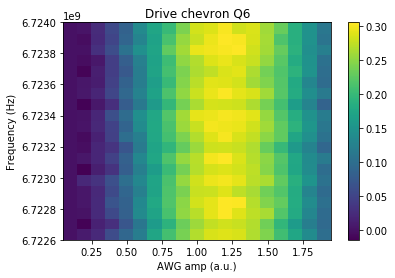

In [307]:
plt.figure()
plt.title('Drive chevron Q6')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(amps,freqs,chevron_Q6_corr)
plt.colorbar()